In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Df_1 - Accesos a internet por cada 100 hogares por provincia

In [5]:
df_1 = pd.read_csv("Data_dfs/df_1.csv")

In [52]:
df_1.head()

,anio,trimestre,provincia,accesos_por_cada_100_hogares
0,2022,4,buenos aires,78.94
1,2022,4,capital federal,122.73
2,2022,4,catamarca,65.77
3,2022,4,chaco,43.62
4,2022,4,chubut,85.57


Búsqueda de valores faltantes. No los hay

In [53]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 864 entries, 0 to 863
Data columns (total 4 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   anio                          864 non-null    int64  
 1   trimestre                     864 non-null    int64  
 2   provincia                     864 non-null    object 
 3   accesos_por_cada_100_hogares  864 non-null    float64
dtypes: float64(1), int64(2), object(1)
memory usage: 27.1+ KB


In [54]:
df_1.shape

(864, 4)

Búsqueda de datos duplicados. En este caso lo importante es que no haya más de una fila con una combinación de Año-Trimestre-Provincia.

In [7]:
columnas = ['anio', 'trimestre', 'provincia']

duplicados = df_1.duplicated(subset=columnas)

filas_duplicadas = df_1[duplicados]

filas_duplicadas

,anio,trimestre,provincia,accesos_por_cada_100_hogares


Voy a empezar a ver los outliers. Para esto, primero voy a usar un boxplot.

Este es el boxplot luego del tratamiento de outliers, abajo hay dos más, ya que la limpieza consistión en dos pasos.

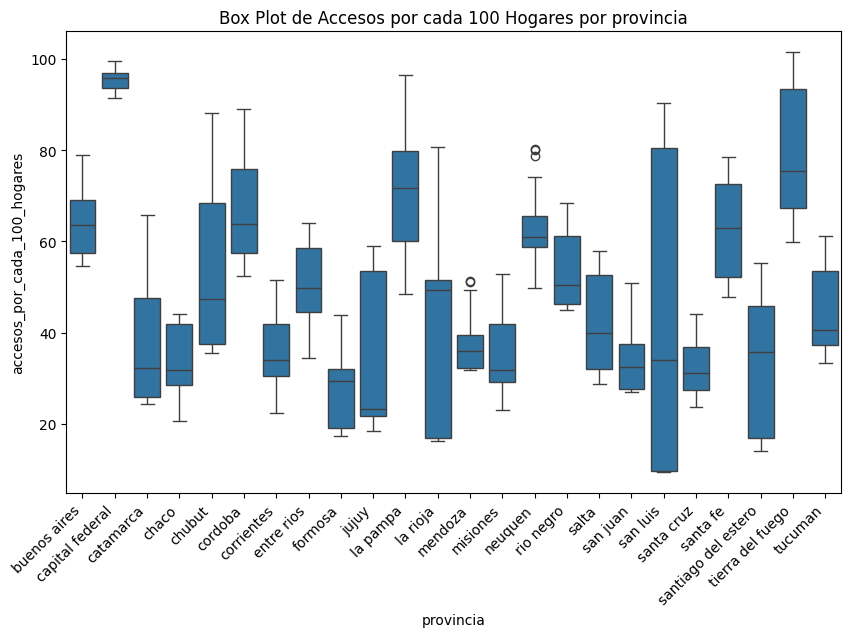

In [66]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='provincia', y='accesos_por_cada_100_hogares', data=df_1)
plt.title('Box Plot de Accesos por cada 100 Hogares por provincia')
plt.xticks(rotation=45, horizontalalignment='right')
plt.show()

Una posible conclusión del boxplot es que hay provincias con mucha más desigualdad en el acceso a internet que otras. Principalmente La Rioja, Jujuy y San Luis particularmente. A pesar de que posiblemente haya espacio para crecimiento en las areas más urbanas del país, las provincias del interior tienen un crecimento potencial para el consumo de internet muchísimo más amplio que las regiones metropolitanas, que dentro de algunos años probablemente estén rozando el límite de crecimiento con respecto a la proporción de hogares con acceso a internet. Un plan de crecimiento a mediano y largo plazo tendría que estar orientado a éstas áreas con menos acceso, aunque implique un esfuerzo mayor con respecto a los recursos invertidos para hacer llegar los servicios.

Boxplot 2, antes de reemplazar los valores mayores a 97

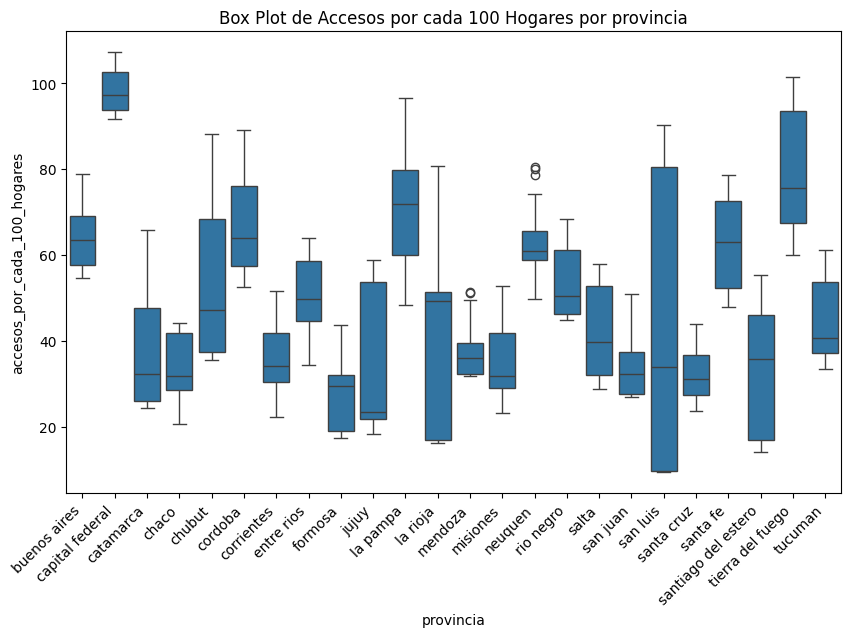

Boxplot 1 anterior a cambiar los datos de Capital Federal

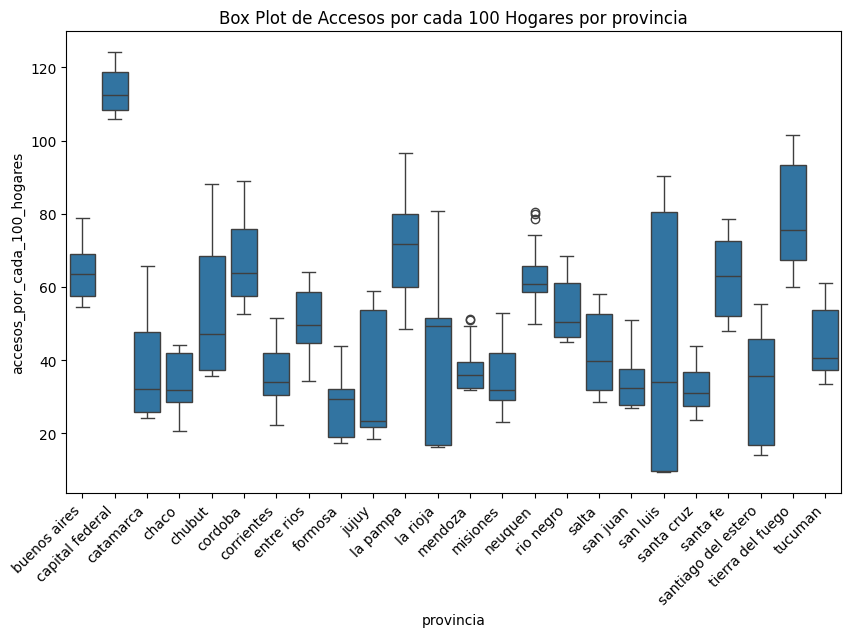

Voy a usar otro método para detectar outliers, aunque va de la mano con el anterior: IQR, o rango intercuartil.

In [5]:
Q1 = df_1['accesos_por_cada_100_hogares'].quantile(0.25)
Q3 = df_1['accesos_por_cada_100_hogares'].quantile(0.75)
IQR = Q3 - Q1

# Definiendo los límites
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identificando outliers potenciales
outliers = df_1[(df_1['accesos_por_cada_100_hogares'] < lower_bound) | (df_1['accesos_por_cada_100_hogares'] > upper_bound)]

In [6]:
outliers = df_1[(df_1['accesos_por_cada_100_hogares'] < lower_bound) | (df_1['accesos_por_cada_100_hogares'] > upper_bound)]

print("Outliers potenciales:")
print(outliers)

Outliers potenciales:
     anio  trimestre        provincia  accesos_por_cada_100_hogares
1    2022          4  capital federal                        122.73
25   2022          3  capital federal                        122.28
49   2022          2  capital federal                        121.31
73   2022          1  capital federal                        111.80
97   2021          4  capital federal                        111.27
121  2021          3  capital federal                        111.27
145  2021          2  capital federal                        110.14
169  2021          1  capital federal                        108.42
193  2020          4  capital federal                        108.31
313  2019          3  capital federal                        112.65
337  2019          2  capital federal                        110.55
361  2019          1  capital federal                        109.20
385  2018          4  capital federal                        108.27
409  2018          3  capi

Según el INDEC, (https://www.indec.gob.ar/uploads/informesdeprensa/mautic_05_22843D61C141.pdf) el 96.1% de los hogares de Capital Federal a finales del 2021 tienen acceso a internet, así que voy a trabajar con ese número. La diferencia entre los valores del Indec, que parecen más razonables, y éstos es de aproximadamente 13.63%. Voy a cambiar los valores de la Capital Federal a un 86.37% de lo que son, es decir, les voy a restar 13,63%.

In [6]:
porcentaje_a_restar = 13.63

df_1.loc[df_1['provincia'] == 'capital federal', 'accesos_por_cada_100_hogares'] *= (1 - porcentaje_a_restar / 100)


Los outliers que tenía, como esperaba, eran de capital federal. Ahora el mismo código para IQR no me devuelve outliers, aunque me siguen pareciendo altos los valores de Capital Federal. Creo que fue un buen paso el restarle un porcentaje a los valores, pero me sigue pareciendo demasiado alto. Creo que es buena idea ahora, ya que no tengo ningún valor demasiado bajo para capital federal, quedarme con el valor más chico por cada año cuando el valor de 'accesos_por_cada_100_hogares' sea mayor que 97, por establecer un límite, aunque éste resulte relativamente arbitrario.

Voy a guardar los valores viejos.

In [7]:
df_viejo = df_1[df_1['provincia'] == 'capital federal']

Primero tengo que encontrar el valor más chico de 'accesos_por_cada_100_hogares' para cada año.

In [8]:
valores_min = df_1[df_1['provincia'] == 'capital federal'].groupby('anio')['accesos_por_cada_100_hogares'].min()

Creo una máscara para filtrar los valores de 'accesos...' > 97 que correspondan a capital federal.
Finalmente, reemplazo 'accesos_por_cada_100_hogares' > 97 con los valores mínimos de cada año. Si en el año no hay valores inferiores a 97, queda el mínimo.

In [9]:
mascara = (df_1['provincia'] == 'capital federal') & (df_1['accesos_por_cada_100_hogares'] > 97)
df_1.loc[mascara, 'accesos_por_cada_100_hogares'] = df_1['anio'].map(valores_min)

In [10]:
df_1[df_1['provincia'] == 'capital federal']

,anio,trimestre,provincia,accesos_por_cada_100_hogares
1,2022,4,capital federal,96.561660
25,2022,3,capital federal,96.561660
49,2022,2,capital federal,96.561660
73,2022,1,capital federal,96.561660
97,2021,4,capital federal,96.103899
121,2021,3,capital federal,96.103899
145,2021,2,capital federal,95.127918
169,2021,1,capital federal,93.642354
193,2020,4,capital federal,93.547347
217,2020,3,capital federal,93.003216


Gráfico de barras de 'accesos_por_cada_100_hogares' por provincia.

<Axes: xlabel='provincia', ylabel='accesos_por_cada_100_hogares'>

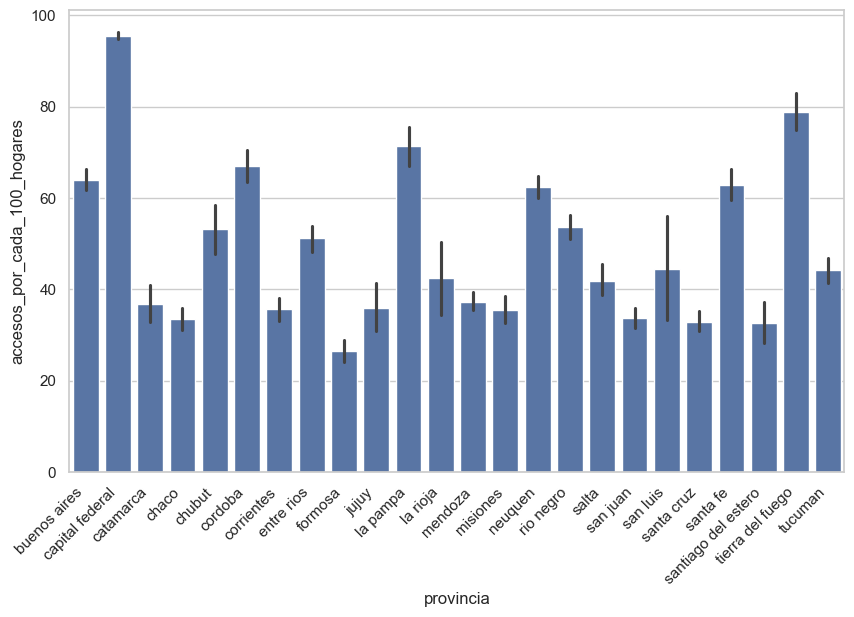

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
plt.xticks(rotation=45, horizontalalignment='right')
sns.barplot(data=df_1, x="provincia", y="accesos_por_cada_100_hogares")


En este gráfico de barras se puede apreciar que, a pesar de que todavía todas las provincias poseen un potencial de crecimiento para su acceso a internet, hay provincias con mucho más potencial que otras. Hay una tendencia en el centro del país (que es donde se ubican las ciudades más grandes) de más acceso, por lo que podría ser aconsejable que el crecimiento esté dirigido hacia el norte y el sur del país. 

En el boxplot siguiente se puede apreciar el crecimiento del promedio en el acceso a internet por hogar, lo cual respalda la teoría expuesta anteriormente: que en un futuro no muy lejano, las provincias del centro del país probablemente hayan alcanzado, o estén cerca de lograr que todos los hogares tengan acceso a internet. Por esto, es importante orientar el negocio a expandir las conexiones de internet hacia otras areas del país con menos accesos, o mejorar las conexiones existentes en las provincias del centro del país.

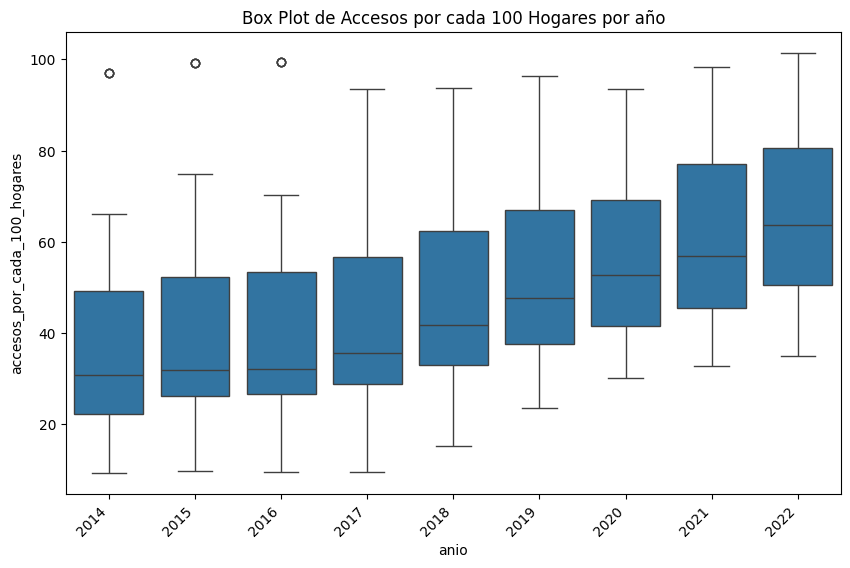

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(x='anio', y='accesos_por_cada_100_hogares', data=df_1)
plt.title('Box Plot de Accesos por cada 100 Hogares por año')
plt.xticks(rotation=45, horizontalalignment='right')
plt.show()

Se me ocurrió hacer un análisis por región del acceso a internet:

In [14]:
regiones = {
    'jujuy': 'noroeste',
    'salta': 'noroeste',
    'tucuman': 'noroeste',
    'santiago del estero': 'noroeste',
    'catamarca': 'noroeste',
    'la rioja': 'noroeste',
    'formosa': 'nordeste',
    'chaco': 'nordeste',
    'misiones': 'nordeste',
    'corrientes': 'nordeste',
    'santa fe': 'pampeana',
    'entre rios': 'pampeana',
    'cordoba': 'pampeana',
    'san luis': 'cuyo',
    'san juan': 'cuyo',
    'mendoza': 'cuyo',
    'la pampa': 'pampeana',
    'buenos aires': 'pampeana',
    'rio negro': 'patagonia',
    'neuquen': 'patagonia',
    'chubut': 'patagonia',
    'santa cruz': 'patagonia',
    'tierra del fuego': 'patagonia',
    'capital federal': 'metropolitana'
}

In [15]:
df_1['region'] = df_1['provincia'].map(regiones)

In [16]:
df_1.head()

,anio,trimestre,provincia,accesos_por_cada_100_hogares,region
0,2022,4,buenos aires,78.94000,pampeana
1,2022,4,capital federal,96.56166,metropolitana
2,2022,4,catamarca,65.77000,noroeste
3,2022,4,chaco,43.62000,nordeste
4,2022,4,chubut,85.57000,patagonia


Boxplot de accesos_por_cada_100_hogares por región:

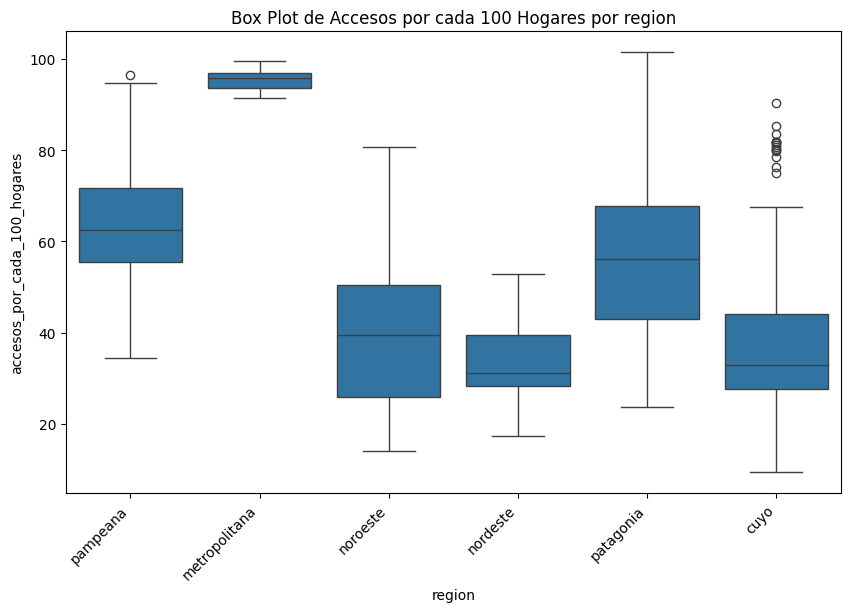

In [17]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='region', y='accesos_por_cada_100_hogares', data=df_1)
plt.title('Box Plot de Accesos por cada 100 Hogares por region')
plt.xticks(rotation=45, horizontalalignment='right')
plt.show()

Scatterplot o gráfico de dispersión de 'accesos_por_cada_100_hogares' por región:

<Axes: xlabel='anio', ylabel='accesos_por_cada_100_hogares'>

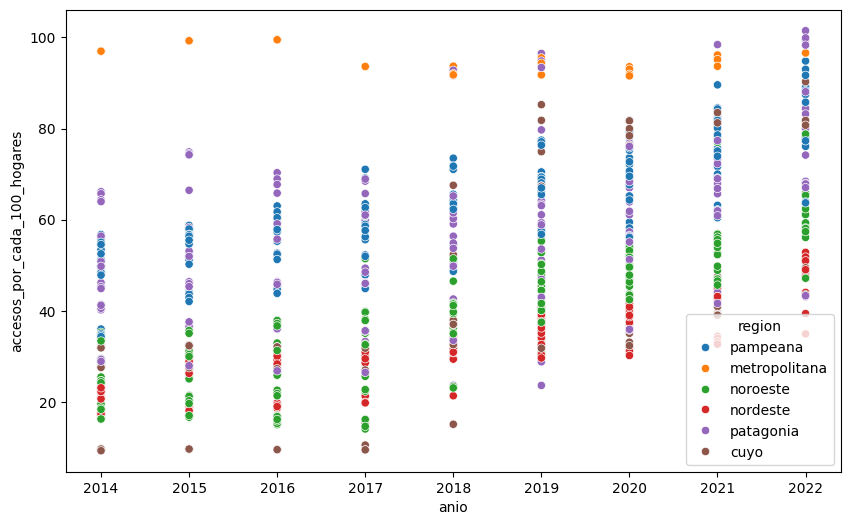

In [18]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_1, x="anio", y="accesos_por_cada_100_hogares", hue="region")

Gráfico de líneas de 'accesos_por_cada_100_hogares' por región:

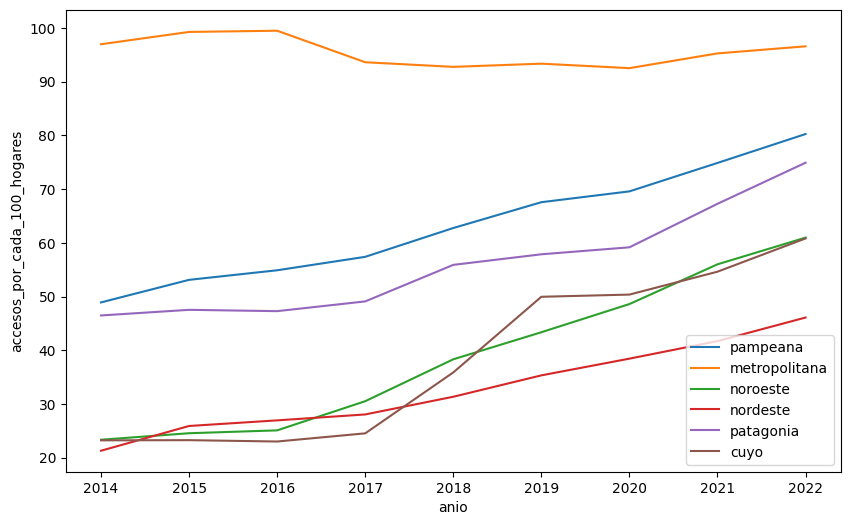

In [19]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_1, x="anio", y="accesos_por_cada_100_hogares", hue="region", errorbar=None)

plt.legend(loc='lower right')

plt.show()

El gráfico es elocuente. Me pareció buena idea hacer un gráfico de lineas porque es ideal para mostrar la evolución de una variable numérica a través del tiempo. No sería tan útil con provincias porque hay muchas y es difícil distinguir entre provincias, pero con los datos divididos por regiones se ven claramente las tendencias (todas postivias) que sigue cada una de éstas, y la diferencia de la variable de accesos a internet para cada región del país. Esta diferencia se debe en gran medida a la mayor pobreza de las areas con menos conexión, y del histórico fácil acceso a nuevas tecnologías y conexiones que tiene Capital Federal por el puerto y por ser el area más poblada del país. 

In [67]:
df_1.to_csv('df_1_mejorado.csv', index=False)

# DF_2

In [12]:
df_2 = pd.read_csv("Data_dfs/df_2.csv")

In [79]:
df_2.head()

,anio,trimestre,accesos_por_cada_100_hogares,accesos_por_cada_100_hab
0,2022,4,77.21,24.15
1,2022,3,76.64,23.95
2,2022,2,75.97,23.72
3,2022,1,73.88,23.05
4,2021,4,73.18,22.81


In [77]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 5 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   anio                          36 non-null     int64  
 1   trimestre                     36 non-null     int64  
 2   accesos_por_cada_100_hogares  36 non-null     float64
 3   accesos_por_cada_100_hab      36 non-null     float64
 4   periodo                       36 non-null     object 
dtypes: float64(2), int64(2), object(1)
memory usage: 1.5+ KB


No hay datos nulos ni faltantes.

In [4]:
df_2.isnull().sum()

anio                            0
trimestre                       0
accesos_por_cada_100_hogares    0
accesos_por_cada_100_hab        0
periodo                         0
dtype: int64

Búsqueda de datos duplicados. En este caso lo importante es que no haya una combinación repetida de Año-Trimestre

In [87]:
columnas = ['anio', 'trimestre']

duplicados = df_2.duplicated(subset=columnas)

filas_duplicadas = df_2[duplicados]

filas_duplicadas

,anio,trimestre,accesos_por_cada_100_hogares,accesos_por_cada_100_hab


Voy a empezar con los outliers: primero voy a hacer dos boxplot. Uno para accesos por cada 100 hogares por año, y el otro de accesos por cada 100 habitantes por año.

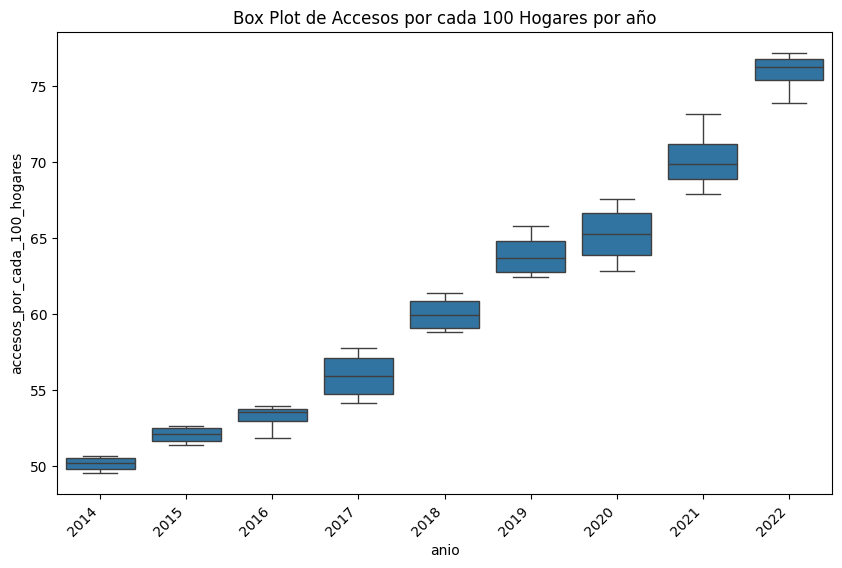

In [80]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='anio', y='accesos_por_cada_100_hogares', data=df_2)
plt.title('Box Plot de Accesos por cada 100 Hogares por año')
plt.xticks(rotation=45, horizontalalignment='right')
plt.show()

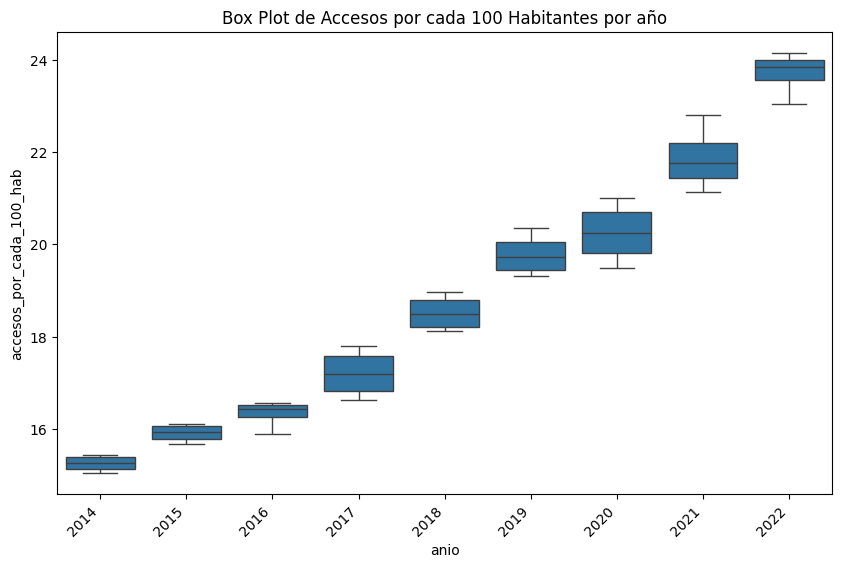

In [81]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='anio', y='accesos_por_cada_100_hab', data=df_2)
plt.title('Box Plot de Accesos por cada 100 Habitantes por año')
plt.xticks(rotation=45, horizontalalignment='right')
plt.show()

Los dos boxplots tienen una tendencia muy similar, casi idéntica. Tienen una pendiente positiva, es decir que para ambas medidas se puede apreciar un crecimiento continuo considerable a través de los años. Para ambos casos, en 8 años se incrementó más de un 50% el promedio de accesos a internet por cada 100 habitantes. 

Ahora voy a aplciar el IQR para evaluar los datos, aunque parecen estar relativamente bien distribuidos.

In [82]:
Q1 = df_2['accesos_por_cada_100_hogares'].quantile(0.25)
Q3 = df_2['accesos_por_cada_100_hogares'].quantile(0.75)
IQR = Q3 - Q1

# Definiendo los límites
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identificando outliers potenciales
outliers = df_2[(df_2['accesos_por_cada_100_hogares'] < lower_bound) | (df_2['accesos_por_cada_100_hogares'] > upper_bound)]

In [83]:
outliers = df_2[(df_2['accesos_por_cada_100_hogares'] < lower_bound) | (df_2['accesos_por_cada_100_hogares'] > upper_bound)]

print("Potential Outliers:")
print(outliers)

Potential Outliers:
Empty DataFrame
Columns: [anio, trimestre, accesos_por_cada_100_hogares, accesos_por_cada_100_hab]
Index: []


El mismo análisis, pero con los datos de accesos por cada 100 habitantes.

In [84]:
Q1 = df_2['accesos_por_cada_100_hab'].quantile(0.25)
Q3 = df_2['accesos_por_cada_100_hab'].quantile(0.75)
IQR = Q3 - Q1

# Definiendo los límites
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identificando outliers potenciales
outliers = df_2[(df_2['accesos_por_cada_100_hab'] < lower_bound) | (df_2['accesos_por_cada_100_hab'] > upper_bound)]

In [85]:
outliers = df_2[(df_2['accesos_por_cada_100_hab'] < lower_bound) | (df_2['accesos_por_cada_100_hab'] > upper_bound)]

print("Potential Outliers:")
print(outliers)

Potential Outliers:
Empty DataFrame
Columns: [anio, trimestre, accesos_por_cada_100_hogares, accesos_por_cada_100_hab]
Index: []


# df_3 Listo

In [20]:
df_3 = pd.read_csv("Data_dfs/df_3.csv")

In [21]:
df_3.head()

,anio,trimestre,banda_ancha_fija,dial_up,Total,periodo
0,2022,4,11,12,11,oct-dic 2022
1,2022,3,11,12,11,jul-sept 2022
2,2022,2,11,12,11,abr-jun 2022
3,2022,1,11,13,11,ene-mar 2022
4,2021,4,10,13,10,oct-dic 2021


In [22]:
df_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   anio              36 non-null     int64 
 1   trimestre         36 non-null     int64 
 2   banda_ancha_fija  36 non-null     int64 
 3   dial_up           36 non-null     int64 
 4   Total             36 non-null     int64 
 5   periodo           36 non-null     object
dtypes: int64(5), object(1)
memory usage: 1.8+ KB


In [23]:
df_3.isnull().sum()

anio                0
trimestre           0
banda_ancha_fija    0
dial_up             0
Total               0
periodo             0
dtype: int64

No hay valores nulos.

Búsqueda de datos duplicados. En este caso lo importante es que no haya una combinación repetida de Año-Trimestre

In [24]:
columnas = ['anio', 'trimestre']

duplicados = df_3.duplicated(subset=columnas)

filas_duplicadas = df_3[duplicados]

filas_duplicadas

,anio,trimestre,banda_ancha_fija,dial_up,Total,periodo


Explorando la fuente de los datos, descubrí que las unidades de los mismos están mezcladas. La columna 'banda_ancha_fija' debería estar en millones, pero para ser más prolijo los voy a cambiar a sus valores exactos reales. 

In [25]:
data_real = {
    (2014, 1): 6362108,
    (2014, 2): 6428329,
    (2014, 3): 6559264,
    (2015, 4): 6559172,
    (2015, 1): 6699714,
    (2015, 2): 6783279,
    (2015, 3): 6902267,
    (2015, 4): 6952289,
    (2016, 1): 6874704,
    (2016, 2): 7097604,
    (2016, 3): 7178340,
    (2016, 4): 7223128,
    (2017, 1): 7277314,
    (2017, 2): 7401134,
    (2017, 3): 7696594,
    (2017, 4): 7842778,
    (2018, 1): 8009981,
    (2018, 2): 8083533,
    (2018, 3): 8320223,
    (2018, 4): 8451841,
    (2019, 1): 8626323,
    (2019, 2): 8938427,
    (2019, 3): 9142891,
    (2019, 4): 8783053,
    (2020, 1): 8802435,
    (2020, 2): 9021040,
    (2020, 3): 9346183,
    (2020, 4): 9561546,
    (2021, 1): 9637956,
    (2021, 2): 9852702,
    (2021, 3): 10075184,
    (2021, 4): 10476933,
    (2022, 1): 10611390,
    (2022, 2): 10946248,
    (2022, 3): 11078691,
    (2022, 4): 11195668
}

In [26]:
df_3['banda_ancha_fija'] = df_3.apply(lambda row: data_real.get((row['anio'], row['trimestre']), row['banda_ancha_fija']), axis=1)

Me di cuenta que la columna dial_up también estaba mal, así que la voy a cambiar también.

In [27]:
valores_nuevos_dial = {
    (2022, 1): 12619,
    (2022, 2): 12436,
    (2022, 3): 12437,
    (2022, 4): 4101,
    (2021, 1): 10016,
    (2021, 2): 10382,
    (2021, 3): 10357,
    (2021, 4): 12861,
    (2020, 1): 9991,
    (2020, 2): 10016,
    (2020, 3): 10016,
    (2020, 4): 10016,
    (2019, 1): 21812,
    (2019, 2): 21754,
    (2019, 3): 21793,
    (2019, 4): 10128,
    (2018, 1): 27072,
    (2018, 2): 26911,
    (2018, 3): 26812,
    (2018, 4): 21814,
    (2017, 1): 28540,
    (2017, 2): 28530,
    (2017, 3): 28349,
    (2017, 4): 27444,
    (2016, 1): 32652,
    (2016, 2): 32475,
    (2016, 3): 28610,
    (2016, 4): 28545,
    (2015, 1): 38018,
    (2015, 2): 32909,
    (2015, 3): 32801,
    (2015, 4): 32542,
    (2014, 1): 36290,
    (2014, 2): 36139,
    (2014, 3): 36007,
    (2014, 4): 39324
}

In [28]:
df_3['dial_up'] = df_3.apply(lambda row: valores_nuevos_dial.get((row['anio'], row['trimestre']), row['dial_up']), axis=1)

Voy a crear una nueva columna 'total' con la suma de los nuevos valores y borrar la anterior.

In [30]:
df_3['total'] = df_3['dial_up'] + df_3['banda_ancha_fija']

Borro 'Total' y cambio el orden de las columnas.

In [32]:
df_3.drop(['Total'], axis=1, inplace=True)

In [ ]:
ordenadas = ['anio','trimestre', 'periodo','banda_ancha_fija','dial_up','total']
df_3 = df_3[ordenadas]

In [106]:
df_3.to_csv('df_3_mejorado.csv', index=False)

# DF_4

In [60]:
df_4 = pd.read_csv("Data_dfs/df_4.csv")

In [61]:
df_4.head()

,anio,trimestre,provincia,banda_ancha_fija,dial_up,Total
0,2022,4,buenos aires,5,6,5
1,2022,4,capital federal,2,2,2
2,2022,4,catamarca,71,1,71
3,2022,4,chaco,144,5,144
4,2022,4,chubut,168,904,169


In [62]:
df_4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 864 entries, 0 to 863
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   anio              864 non-null    int64 
 1   trimestre         864 non-null    int64 
 2   provincia         864 non-null    object
 3   banda_ancha_fija  864 non-null    int64 
 4   dial_up           864 non-null    int64 
 5   Total             864 non-null    int64 
dtypes: int64(5), object(1)
memory usage: 40.6+ KB


No hay datos nulos acá. Originalmente tenía dos nulos en 'dial_ip' pero eran = 0. Ya fueron reemplazados. 

Búsqueda de datos duplicados. En este caso, lo importante es que no haya alguna combinación de Año-Trimestre-Provincia que haya sido registrada más de una vez.

In [63]:
columnas = ['anio', 'trimestre', 'provincia']

duplicados = df_4.duplicated(subset=columnas)

filas_duplicadas = df_4[duplicados]

filas_duplicadas

,anio,trimestre,provincia,banda_ancha_fija,dial_up,Total


In [64]:
df_4.head()

,anio,trimestre,provincia,banda_ancha_fija,dial_up,Total
0,2022,4,buenos aires,5,6,5
1,2022,4,capital federal,2,2,2
2,2022,4,catamarca,71,1,71
3,2022,4,chaco,144,5,144
4,2022,4,chubut,168,904,169


Parece que voy a tener el mismo problema que para el df_3. Los valores no están en las unidades correctas. Lo más sencillo sería multiplicar todo * 1000000 pero tengo un margen de error de 1 millon, y es demasiado. Prefiero recurrir a la documnetación de la página fuente y corregir los datos de manera precisa. Para esto, voy a tener que importar el excel original:

In [65]:
excel_df = pd.read_excel('Excel_original/excel_4.xlsx', sheet_name='Dial-BAf')

In [66]:
excel_df.head(10)

,Año,Trimestre,Provincia,Banda ancha fija,Dial up,Total
0,2022,4,Buenos Aires,4788466,6199.0,4794665
1,2022,4,Capital Federal,1549781,2145.0,1551926
2,2022,4,Catamarca,70908,1.0,70909
3,2022,4,Chaco,143658,5.0,143663
4,2022,4,Chubut,167855,904.0,168759
5,2022,4,Córdoba,1049592,68.0,1049660
6,2022,4,Corrientes,155449,4.0,155453
7,2022,4,Entre Ríos,270952,22.0,270974
8,2022,4,Formosa,61840,0.0,61840
9,2022,4,Jujuy,118218,0.0,118218


In [67]:
excel_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 864 entries, 0 to 863
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Año               864 non-null    int64  
 1   Trimestre         864 non-null    int64  
 2   Provincia         864 non-null    object 
 3   Banda ancha fija  864 non-null    int64  
 4   Dial up           862 non-null    float64
 5   Total             864 non-null    int64  
dtypes: float64(1), int64(4), object(1)
memory usage: 40.6+ KB


In [68]:
excel_df['Dial up'] = excel_df['Dial up'].fillna(0)

In [58]:
excel_df.dtypes

anio                 int64
trimestre            int64
provincia           object
banda_ancha_fija     int64
dial_up              int32
total                int64
dtype: object

In [69]:
excel_df['Dial up'] = excel_df['Dial up'].astype(int)

In [70]:
nuevas_columnas = {
    'Año': 'anio',
    'Trimestre': 'trimestre',
    'Provincia': 'provincia',
    'Banda ancha fija': 'banda_ancha_fija',
    'Dial up': 'dial_up',
    'Total': 'total'
}
excel_df.rename(columns=nuevas_columnas, inplace=True)


In [71]:
import unicodedata

for column in excel_df.columns:
    if excel_df[column].dtype == 'object':
        excel_df[column] = excel_df[column].str.lower().apply(lambda x: unicodedata.normalize('NFKD', x).encode('ASCII', 'ignore').decode('utf-8'))

Ya le hice el mismo tratamiento al archivo excel. Ahora voy a poder reemplazar los valores sin problemas.


In [78]:
columnas_a_reemplazar = ['banda_ancha_fija', 'dial_up', 'Total']

In [81]:
excel_df.head(1)

,anio,trimestre,provincia,banda_ancha_fija,dial_up,total
0,2022,4,buenos aires,4788466,6199,4794665


In [82]:
columnas_a_reemplazar = ['banda_ancha_fija', 'dial_up', 'Total']
df_4[columnas_a_reemplazar] = excel_df[['banda_ancha_fija', 'dial_up', 'total']]

In [85]:
df_4['total'] = df_4['Total']

In [87]:
df_4.drop(columns=['Total'], inplace=True)

In [76]:
df_4.shape

(864, 6)

Guardando el archivo limpio

In [164]:
df_4.to_csv('df_4_mejorado.csv', index=False)

# DF_5

In [88]:
df_5 = pd.read_csv("Data_dfs/df_5.csv")

Nuevamente, las unidades de los datos estan mal. Voy a importar el archivo excel original. Luego, voy a tener que dejarlo con el mismo tipo de datos que df_5


In [89]:
excel_5 = pd.read_excel('Excel_original/excel_5.xlsx', sheet_name='Totales')

In [213]:
excel_5.head()

,Año,Trimestre,ADSL,Cablemodem,Fibra óptica,Wireless,Otros,Total,Periodo
0,2022,4,1315373,6037457,3060575,572969,221740,11208114,Oct-Dic 2022
1,2022,3,1395277,6031970,2871541,557110,235230,11091128,Jul-Sept 2022
2,2022,2,1468333,5979214,2723285,556243,231609,10958684,Abr-Jun 2022
3,2022,1,1533240,6073426,2219533,545814,251996,10624009,Ene-Mar 2022
4,2021,4,1657615,5984240,2072236,523107,252596,10489794,Oct-Dic 2021


In [90]:
excel_5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Año           36 non-null     int64 
 1   Trimestre     36 non-null     int64 
 2   ADSL          36 non-null     int64 
 3   Cablemodem    36 non-null     int64 
 4   Fibra óptica  36 non-null     int64 
 5   Wireless      36 non-null     int64 
 6   Otros         36 non-null     int64 
 7   Total         36 non-null     int64 
 8   Periodo       36 non-null     object
dtypes: int64(8), object(1)
memory usage: 2.7+ KB


No hay valores nulos

In [94]:
excel_5.isnull().sum()

Año             0
Trimestre       0
ADSL            0
Cablemodem      0
Fibra óptica    0
Wireless        0
Otros           0
Total           0
Periodo         0
dtype: int64

In [92]:
df_5.head()

,anio,trimestre,adsl,cablemodem,fibra_optica,wireless,otros,total,periodo
0,2022,4,1,6,3,573,222,11,oct-dic 2022
1,2022,3,1,6,3,557,235,11,jul-sept 2022
2,2022,2,1,6,3,556,232,11,abr-jun 2022
3,2022,1,2,6,2,546,252,11,ene-mar 2022
4,2021,4,2,6,2,523,253,10,oct-dic 2021


Voy a reemplazar los valores de df_5. Para esto, creo una lista de las columnas de df_5 que quiero reemplazar, y otra con las columnas de excel con las que quiero reemplazarlas.

In [96]:
columnas_a_reemplazar = ['adsl', 'cablemodem', 'fibra_optica', 'wireless', 'otros', 'total']
df_5[columnas_a_reemplazar] = excel_5[['ADSL', 'Cablemodem', 'Fibra óptica', 'Wireless', 'Otros', 'Total']]

In [97]:
df_5.head(2)

,anio,trimestre,adsl,cablemodem,fibra_optica,wireless,otros,total,periodo
0,2022,4,1315373,6037457,3060575,572969,221740,11208114,oct-dic 2022
1,2022,3,1395277,6031970,2871541,557110,235230,11091128,jul-sept 2022


Voy a chequear que no haya duplicados. En este dataframe, lo importante es que la combinación Año-Trimestre no esté repetida:

In [217]:
columnas = ['anio', 'trimestre']

duplicados = df_5.duplicated(subset=columnas)

filas_duplicadas = df_5[duplicados]

filas_duplicadas

,anio,trimestre,adsl,cablemodem,fibra_optica,wireless,otros,total,periodo


- Búsqueda de outliers:

    - ADSL

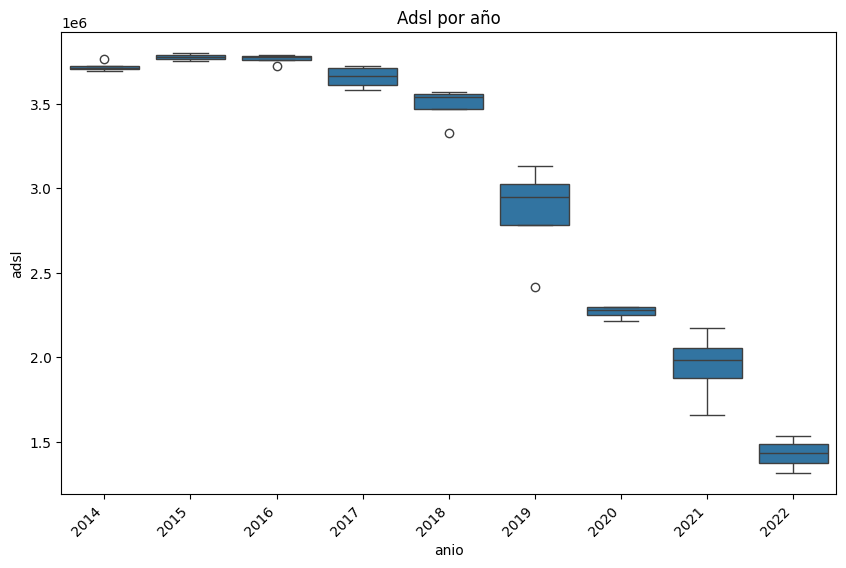

In [98]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='anio', y='adsl', data=df_5)
plt.title('Adsl por año')
plt.xticks(rotation=45, horizontalalignment='right')
plt.show()

ADSL (Asimetric Digital Subscriber Line o Línea de Abonado Digital Asimétrica) es una tecnología de módem que transforma las líneas telefónicas o el par de cobre del abonado en líneas de alta velocidad permanentemente establecidas y pagando una única cantidad mensual. Evidentemente es una tecnología que se está usando cada vez menos por lo que puede verse en el gráfico anterior. Por esto, probablemente no sean recomendables inversiones en esta tecnología. 

    - Cablemodem

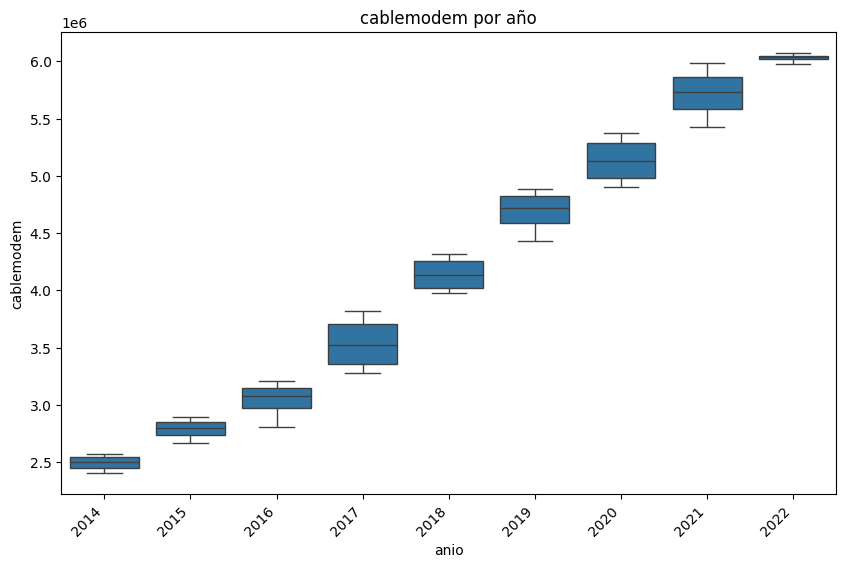

In [219]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='anio', y='cablemodem', data=df_5)
plt.title('cablemodem por año')
plt.xticks(rotation=45, horizontalalignment='right')
plt.show()

El cablemódem es un tipo especial de módem diseñado para modular y demodular la señal de datos sobre una infraestructura de televisión por cable. En telecomunicaciones, Internet por cable es un tipo de acceso de banda ancha a Internet. Al contrario de la tecnología ADSL, desde el 2014 su uso está incrementando mucho, por lo que inversiones en esta tecnología podrían ser recomendables luego de un análisis de mercado y crecimiento potencial.

    - Fibra óptica

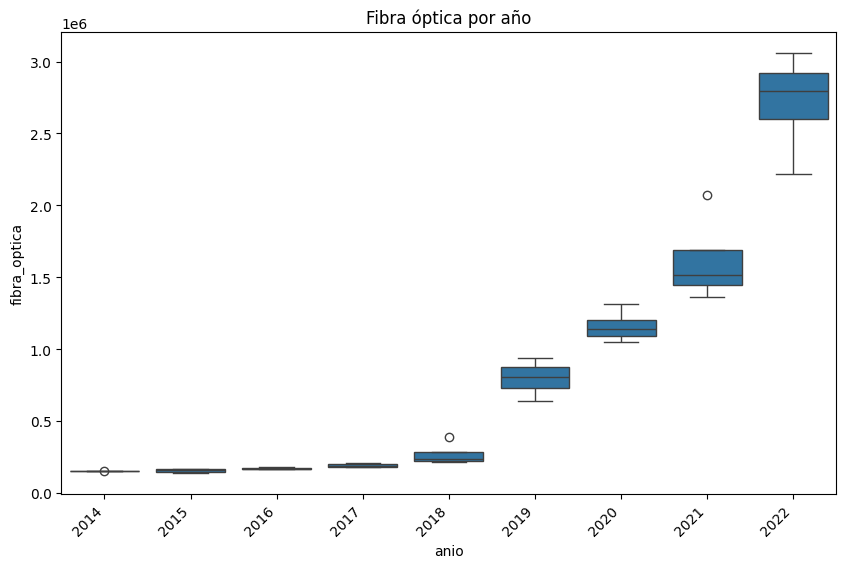

In [220]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='anio', y='fibra_optica', data=df_5)
plt.title('Fibra óptica por año')
plt.xticks(rotation=45, horizontalalignment='right')
plt.show()

La fibra óptica es un medio físico de transmisión de información, usual en redes de datos y telecomunicaciones, que consiste en un filamento delgado de vidrio o de plástico, a través del cual viajan pulsos de luz láser o led, en la cual se contienen los datos a transmitir. Su uso está creciendo mucho en los últimos años, ya que se trata de una de las tecnologías más potentes a la hora de ofrecer un servicio de internet. La tecnología de fibra ópitica tiene mucho potencial de crecimiento en el país, aunque su implementación requiera de inversiones considerables para logarar llevarla a lugares del país donde todavía no es físicamente accesible. 

    - Wireless

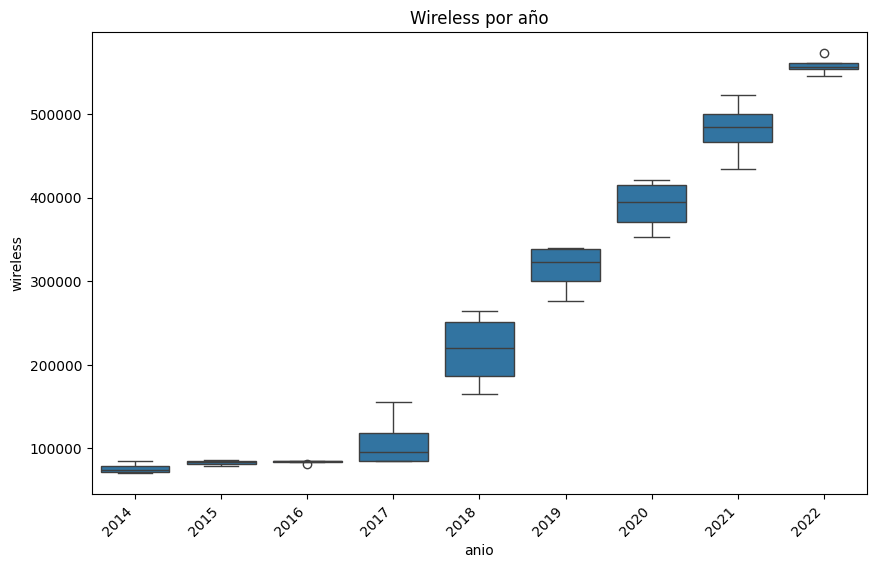

In [221]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='anio', y='wireless', data=df_5)
plt.title('Wireless por año')
plt.xticks(rotation=45, horizontalalignment='right')
plt.show()

La tecnlogía wireless también se encuentra en crecimiento, aunque sus números son mucho menores que los de las tecnologías anteriormente, como se puede ver en el boxplot a continuación.


<Axes: >

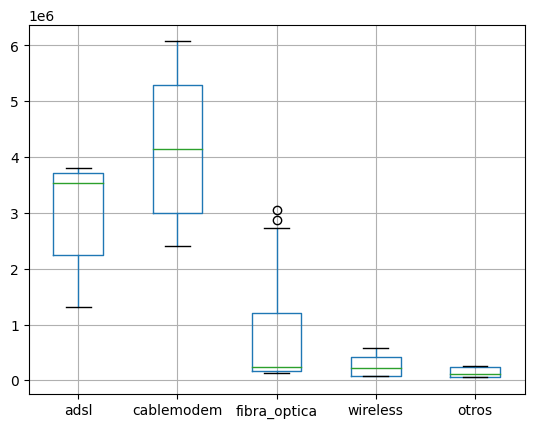

In [223]:
df_5.boxplot(column=['adsl', 'cablemodem', 'fibra_optica', 'wireless',
'otros'])

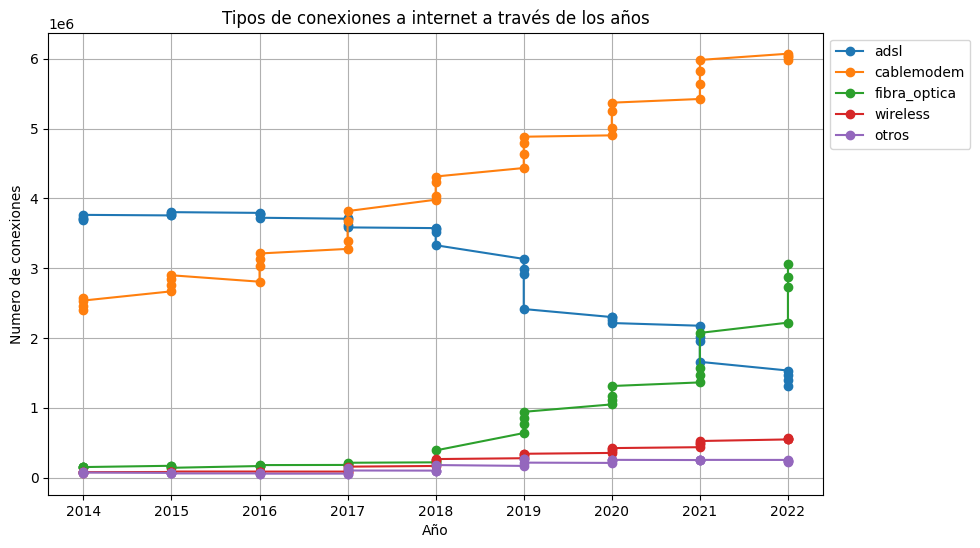

In [210]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(df_5['anio'], df_5['adsl'], marker='o', label='adsl')
plt.plot(df_5['anio'], df_5['cablemodem'], marker='o', label='cablemodem')
plt.plot(df_5['anio'], df_5['fibra_optica'], marker='o', label='fibra_optica')
plt.plot(df_5['anio'], df_5['wireless'], marker='o', label='wireless')
plt.plot(df_5['anio'], df_5['otros'], marker='o', label='otros')

plt.xlabel('Año')
plt.ylabel('Numero de conexiones')
plt.title('Tipos de conexiones a internet a través de los años')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid()

plt.show()

Como se puede ver en el gráfico anterior, las tecnologías que más crecimiento han sufrido en los últimos años son el cablemodem y la fibra óptica. Sin enbargo, la fibra óptica tiene muchísimo más potencial para crecer en los próximos años, especialmente en áreas donde su acceso no resulta tan complicado, por lo que es una oportunidad de inversión que no debe ser pasada por alto. Es importante recalcar que la fibra óptica no sólo va a llenar los espacios donde no haya conexiones preexistentes a internet, sino que tiene el potencial, y de hecho también lo está haciendo, de reemplazar a las tecnologías anteriores que presentan rendimientos muy inferiores.

A continuación un gráfico similar al anterior, pero entre los años 2019 y 2022.

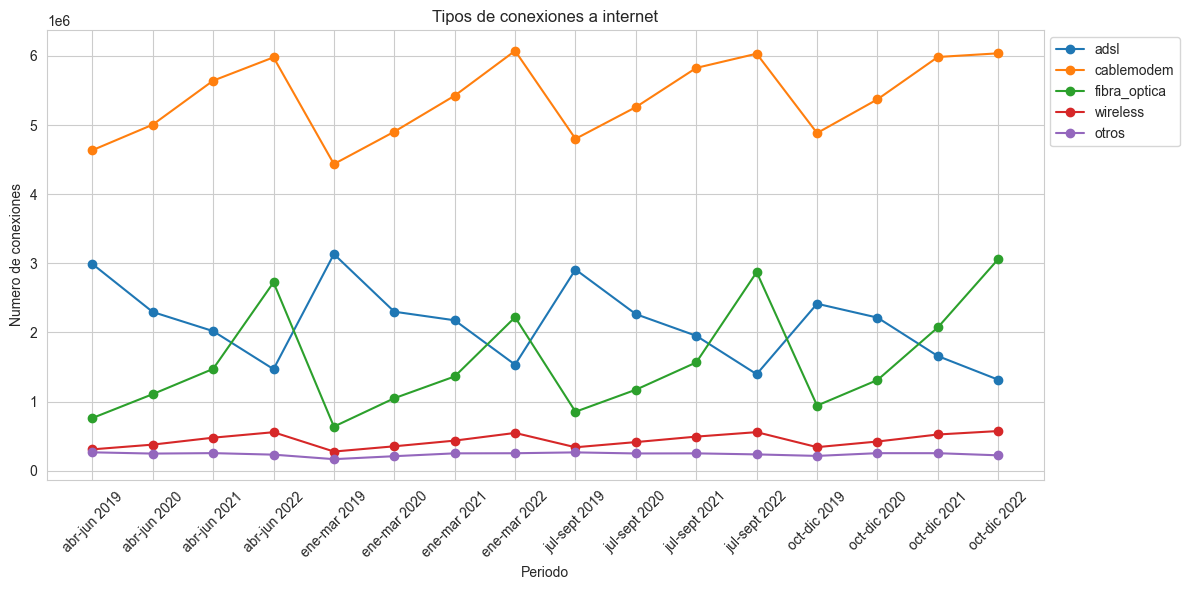

In [99]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df_filtrado = df_5[(df_5['anio'] >= 2019) & (df_5['anio'] <= 2022)]

tipos_conexiones = ['adsl', 'cablemodem', 'fibra_optica', 'wireless', 'otros']
df_agrupado = df_filtrado.groupby('periodo')[tipos_conexiones].sum().reset_index()

sns.set_style('whitegrid')

plt.figure(figsize=(12, 6))

for conexion in tipos_conexiones:
    plt.plot(df_agrupado['periodo'], df_agrupado[conexion], marker='o', label=conexion)

plt.xlabel('Periodo')
plt.xticks(rotation=45)
plt.ylabel('Numero de conexiones')
plt.title('Tipos de conexiones a internet')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()

In [1]:
df_5.to_csv('df_5_mejorado.csv', index=False)

NameError: name 'df_5' is not defined

# DF_6

In [3]:
import pandas as pd

In [4]:
df_6 = pd.read_csv("Data_dfs/df_6.csv")

In [5]:
df_6.head(9)

,anio,trimestre,provincia,adsl,cablemodem,fibra_optica,wireless,otros,total
0,2022,4,buenos aires,326,3,1,130,72,5
1,2022,4,capital federal,139,1,139,5,32,2
2,2022,4,catamarca,9,11,47,1,2,71
3,2022,4,chaco,25,61,47,8,3,144
4,2022,4,chubut,45,74,10,31,9,169
5,2022,4,cordoba,152,457,367,62,11,1
6,2022,4,corrientes,34,80,27,9,5,155
7,2022,4,entre rios,56,136,41,26,13,271
8,2022,4,formosa,14,17,13,18,227,62


Mismo problema con las unidades. Voy a buscar el excel original para reemplazarlos.

In [6]:
excel_6 = pd.read_excel('Excel_original/excel_6.xlsx', sheet_name='Accesos Por Tecnología')

In [7]:
excel_6.head()

,Año,Trimestre,Provincia,ADSL,Cablemodem,Fibra óptica,Wireless,Otros,Total,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17
0,2022,4,Buenos Aires,325908.0,2767247.0,1499149.0,129910.0,72451.0,4794665.0,NaN,NaN,Buenos Aires,325908.0,2767247.0,1499149.0,129910.0,72451.0,4794665.0
1,2022,4,Capital Federal,138753.0,1238196.0,138548.0,4603.0,31826.0,1551926.0,NaN,NaN,Capital Federal,138753.0,1238196.0,138548.0,4603.0,31826.0,1551926.0
2,2022,4,Catamarca,8952.0,10998.0,47337.0,1379.0,2243.0,70909.0,NaN,NaN,Catamarca,8952.0,10998.0,47337.0,1379.0,2243.0,70909.0
3,2022,4,Chaco,24582.0,61265.0,47285.0,7957.0,2574.0,143663.0,NaN,NaN,Chaco,24582.0,61265.0,47285.0,7957.0,2574.0,143663.0
4,2022,4,Chubut,45450.0,73923.0,9815.0,30721.0,8850.0,168759.0,NaN,NaN,Chubut,45450.0,73923.0,9815.0,30721.0,8850.0,168759.0


En este df hay 2 tablas de datos. Voy a crear dos dfs:

In [8]:
columnas_unnamed = [col for col in excel_6.columns if col.startswith('Unnamed')]

In [9]:
excel_6.drop(columns=columnas_unnamed, inplace=True)

In [10]:
df_6.head(1)

,anio,trimestre,provincia,adsl,cablemodem,fibra_optica,wireless,otros,total
0,2022,4,buenos aires,326,3,1,130,72,5


In [11]:
excel_6.head(1)

,Año,Trimestre,Provincia,ADSL,Cablemodem,Fibra óptica,Wireless,Otros,Total
0,2022,4,Buenos Aires,325908.0,2767247.0,1499149.0,129910.0,72451.0,4794665.0


In [12]:
columnas_a_reemplazar = ['adsl', 'cablemodem', 'fibra_optica', 'wireless', 'otros', 'total']
df_6[columnas_a_reemplazar] = excel_6[['ADSL', 'Cablemodem', 'Fibra óptica', 'Wireless', 'Otros', 'Total']]

In [13]:
cols_conv = ['adsl', 'cablemodem', 'fibra_optica', 'wireless', 'otros', 'total']

In [14]:
df_6[cols_conv] = df_6[cols_conv].astype(int)

In [15]:
df_6.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 864 entries, 0 to 863
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   anio          864 non-null    object
 1   trimestre     864 non-null    object
 2   provincia     864 non-null    object
 3   adsl          864 non-null    int32 
 4   cablemodem    864 non-null    int32 
 5   fibra_optica  864 non-null    int32 
 6   wireless      864 non-null    int32 
 7   otros         864 non-null    int32 
 8   total         864 non-null    int32 
dtypes: int32(6), object(3)
memory usage: 40.6+ KB


In [16]:
df_6.isnull().sum()

anio            0
trimestre       0
provincia       0
adsl            0
cablemodem      0
fibra_optica    0
wireless        0
otros           0
total           0
dtype: int64

No hay nulos.

Buscando duplicados. En este caso lo importante es que no haya combinaciones de 'anio'-'trimestre'-'provincia' que se repitan.

In [258]:
columnas = ['anio', 'trimestre', 'provincia']

duplicados = df_6.duplicated(subset=columnas)

filas_duplicadas = df_6[duplicados]

filas_duplicadas

,anio,trimestre,provincia,adsl,cablemodem,fibra_optica,wireless,otros,total


In [18]:
df_6.to_csv('df_6_mejorado.csv', index=False)

# DF_8 - Media de mbps de bajada por trimestre.

In [23]:
import pandas as pd

In [24]:
df_8 = pd.read_csv("Data_dfs/df_8.csv")

In [25]:
df_8.head()

,anio,trimestre,mbps_media_de_bajada,periodo
0,2022,4,10.656,oct-dic 2022
1,2022,3,6.246,jul-sept 2022
2,2022,2,5.844,abr-jun 2022
3,2022,1,5.511,ene-mar 2022
4,2021,4,5.234,oct-dic 2021


A continuación se muestran dos gráficos boxplot. El primero que está justo a continuación está corregido, y el siguiente es la versión anterior con los datos incorrectos provistos por la página. Este caso nos demuestra la utilidad de los boxplot para detectar outliers.

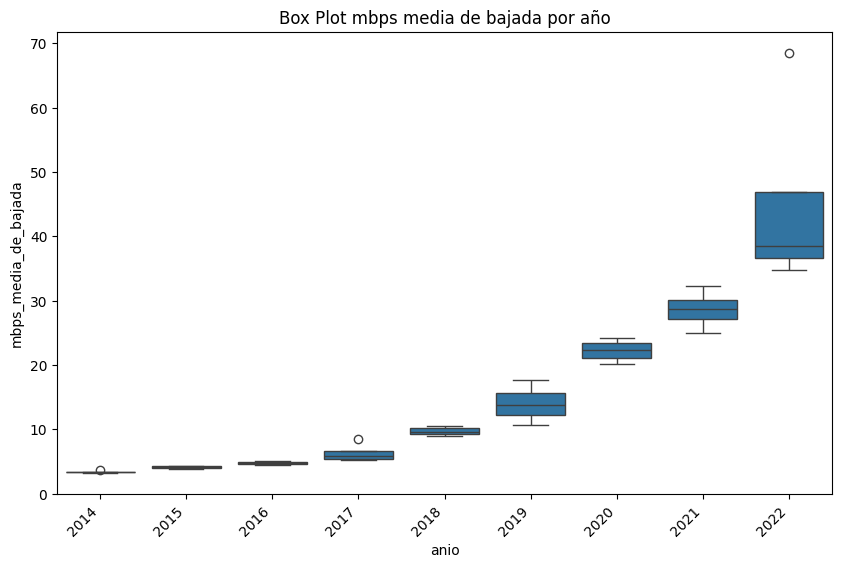

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(x='anio', y='mbps_media_de_bajada', data=df_8)
plt.title('Box Plot mbps media de bajada por año')
plt.xticks(rotation=45, horizontalalignment='right')
plt.show()

Este boxplot muestra los datos que estaban en la página. Nos demuestra que hay algo mal con los datos. Los valores hasta 2017 estan claramente mal. Los cambié por los datos provistos por el excel para este grupo de datos en particular. Tengo la hipótesis de que se sumaron y quedaron excesivamente grandes.

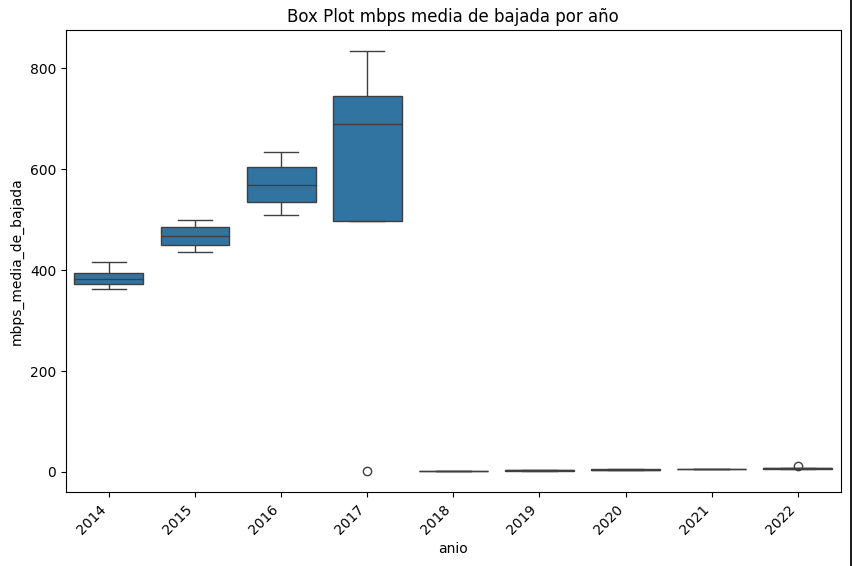

In [28]:
excel_8 = pd.read_excel('Excel_original/excel_8.xlsx', sheet_name='Velocidad % por prov')

In [132]:
excel_8.head()

,Año,Trimestre,Provincia,Mbps (Media de bajada)
0,2022,4,Buenos Aires,111.00
1,2022,4,Capital Federal,182.86
2,2022,4,Catamarca,83.33
3,2022,4,Chaco,104.02
4,2022,4,Chubut,15.92


Chequeando que el valor maximo no sea exagerado. Aunque hay valores bastante altos, estos valores parecen correctos. 

In [27]:
excel_8['Mbps (Media de bajada)'].max()

182.86

Necesito sacar el promedio de 'mbps_media_de_bajada' para cada trimestre de cada año en el df_8. Para esto tengo que usar los valores de excel_8.


Calculando el promedio de bajada agrupando por 'año' y 'trimestre'

In [29]:
promedio_mbps_excel_8 = excel_8.groupby(['Año', 'Trimestre'])['Mbps (Media de bajada)'].mean().reset_index()

Merge de los dos df para tener el nuevo promedio de bajada por trimestre en df_8.

In [30]:
df_8 = df_8.merge(promedio_mbps_excel_8, left_on=['anio', 'trimestre'], right_on=['Año', 'Trimestre'], how='left')


In [31]:
df_8.head()

,anio,trimestre,mbps_media_de_bajada,periodo,Año,Trimestre,Mbps (Media de bajada)
0,2022,4,10.656,oct-dic 2022,2022,4,68.502083
1,2022,3,6.246,jul-sept 2022,2022,3,39.657500
2,2022,2,5.844,abr-jun 2022,2022,2,37.295833
3,2022,1,5.511,ene-mar 2022,2022,1,34.711250
4,2021,4,5.234,oct-dic 2021,2021,4,32.287545


Drop de las columnas innecesarias

In [32]:
df_8.drop(columns=['mbps_media_de_bajada', 'Año', 'Trimestre'], inplace=True)

Renombrar y redondear la columna 'Mbps (Media de bajada)' nuevamente:

In [33]:
df_8.rename(columns={'Mbps (Media de bajada)': 'mbps_media_de_bajada'}, inplace=True)

In [34]:
df_8['mbps_media_de_bajada'] = df_8['mbps_media_de_bajada'].round(2)

Buscando que no haya duplicados. En este caso lo importante es que no haya más de una combinación de anio-trimestre

In [53]:
columnas = ['anio', 'trimestre']

duplicados = df_8.duplicated(subset=columnas)

filas_duplicadas = df_8[duplicados]

filas_duplicadas

,anio,trimestre,periodo,mbps_media_de_bajada


Guardando un archivo nuevo limpio.

In [48]:
df_8.to_csv('df_8_mejorado.csv', index=False)

# Df_9 - Velocidad de bajada de provincias por trimestre

Importo pandas y abro el archivo .csv donde tengo los datos.

In [80]:
import pandas as pd

In [81]:
df_9 = pd.read_csv("Data_dfs/df_9.csv")

In [82]:
df_9.head()

,anio,trimestre,provincia,mbps_media_de_bajada
0,2022,4,buenos aires,111.000
1,2022,4,capital federal,18.286
2,2022,4,catamarca,8.333
3,2022,4,chaco,10.402
4,2022,4,chubut,1.592


In [88]:
df_9_capital = df_9[df_9['provincia'] == 'capital federal']

El siguiente boxplot muestra el crecimiento del promedio de la velocidad de bajada (Mbps) para Capital Federal a través de los años. 

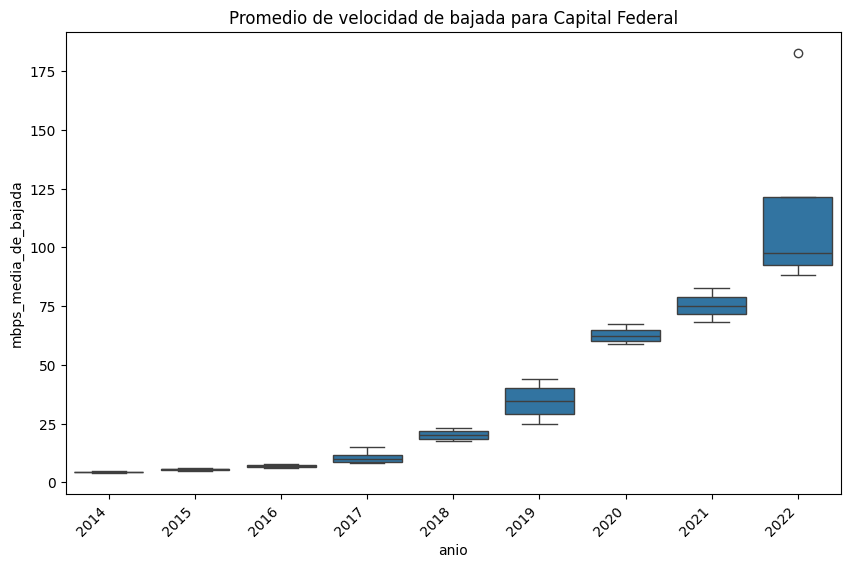

In [89]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(x='anio', y='mbps_media_de_bajada', data=df_9_capital)
plt.title('Promedio de velocidad de bajada para Capital Federal')
plt.xticks(rotation=45, horizontalalignment='right')
plt.show()

Este es el boxplot antes de cambiar los valores de velocidad de bajada. Claramente hay un problema con los datos, que se soluciona importando los datos del excel original.

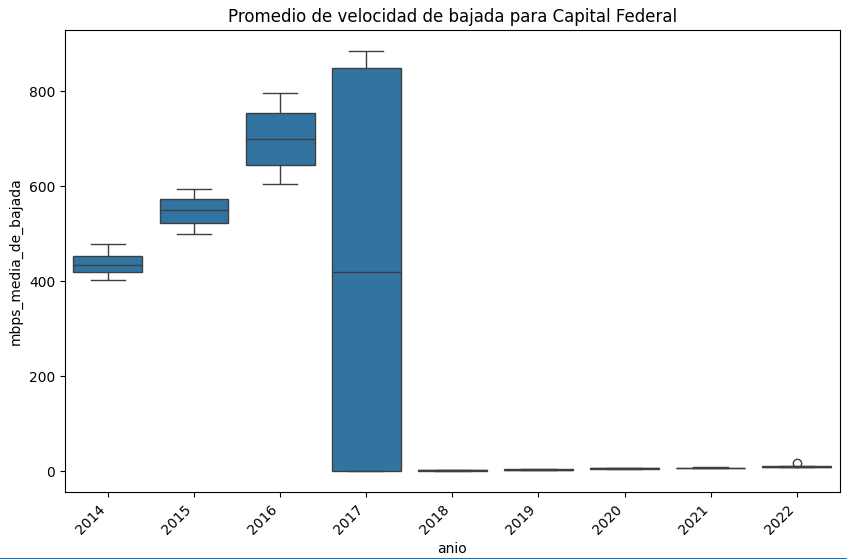

In [86]:
excel_9 = pd.read_excel('Excel_original/excel_9.xlsx', sheet_name='Velocidad % por prov')

In [72]:
excel_9.head()

,Año,Trimestre,Provincia,Mbps (Media de bajada)
0,2022,4,Buenos Aires,111.00
1,2022,4,Capital Federal,182.86
2,2022,4,Catamarca,83.33
3,2022,4,Chaco,104.02
4,2022,4,Chubut,15.92


Maximo de mbps de bajada antes y después de cambiar los datos:

In [85]:
df_9['mbps_media_de_bajada'].max()

988.0

In [74]:
df_9['mbps_media_de_bajada'].max()

182.86

Reemplazo los valores de df_9['mbps_media_de_bajada'] con los del excel original.

In [87]:
df_9['mbps_media_de_bajada'] = excel_9['Mbps (Media de bajada)']

Buscando valores nulos. No los hay.

In [90]:
df_9.isnull().sum()

anio                    0
trimestre               0
provincia               0
mbps_media_de_bajada    0
dtype: int64

Valores duplicados. En este caso lo importante es que no haya combinaciones de anio-trimestre-provincia.

In [78]:
columnas = ['anio', 'trimestre', 'provincia']

duplicados = df_9.duplicated(subset=columnas)

filas_duplicadas = df_9[duplicados]

filas_duplicadas

,anio,trimestre,provincia,mbps_media_de_bajada


En el siguiente gráfico de barras se puede apreciar la velocidad media de bajada (Mbps) por provincia entre los años 2014 y 2022.

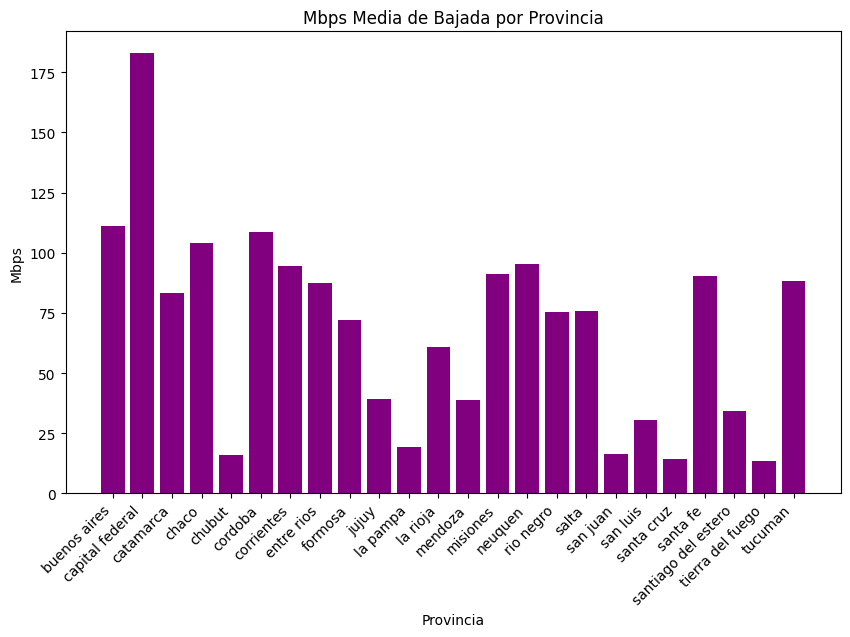

In [67]:
import matplotlib.pyplot as plt
import pandas as pd

plt.figure(figsize=(10, 6))

provincias = df_9['provincia']
mbps = df_9['mbps_media_de_bajada']

plt.bar(provincias, mbps, color='purple')

plt.title('Mbps Media de Bajada por Provincia')
plt.xlabel('Provincia')
plt.ylabel('Mbps')
plt.xticks(rotation=45, ha='right')

plt.show()

La disparidad de velocidad media de bajada en Mbps es aproximadamente como pensé que iba a ser: Capital Federal presenta valores mucho más altos que el resto del país, llegando a ser incluso casi 75% más alto que la Provincia de Buenos Aires, en segundo lugar de media de velocidad de bajada. Esto da cuenta de cierta desigualdad en el acceso a internet en las distintas partes del país, lo cual tenga que ver probablemente con razones geopolíticas del país (Capital Federal es, claro, la capital, y tiene la densidad poblacional más alta del país, además de ser un núcleo económico importantísimo). 

In [79]:
df_9.to_csv('df_9_mejorado.csv', index=False)

# Df_10 - Velocidad de descarga por trimestre.

In [91]:
import pandas as pd

In [92]:
df_10 = pd.read_csv("Data_dfs/df_10.csv")

En este df tengo datos con dos '.', lo cual es un problema, y me genera confusión acerca de qué significa cada '.'. Nuevamente voy a buscar en el df original a ver si lo puedo solucionar.

In [93]:
excel_10 = pd.read_excel('Excel_original/excel_10.xlsx', sheet_name='Totales')

In [94]:
excel_10.head()

,Año,Trimestre,Hasta 512 kbps,Entre 512 Kbps y 1 Mbps,Entre 1 Mbps y 6 Mbps,Entre 6 Mbps y 10 Mbps,Entre 10 Mbps y 20 Mbps,Entre 20 Mbps y 30 Mbps,Más de 30 Mbps,OTROS,Total
0,2022,4,31981,85668,1075272,1109421,765015,335573,7410902,394282,11208114
1,2022,3,33013,96727,1161370,1151906,823505,479822,6995750,349035,11091128
2,2022,2,33667,99498,1193090,1197030,856562,485321,6741922,351594,10958684
3,2022,1,34890,104840,1263273,1209148,967508,509830,6336187,198333,10624009
4,2021,4,41262,28521,1413208,1245333,976539,558358,6032322,194251,10489794


In [95]:
df_10.head()

,anio,trimestre,hasta_512_kbps,entre_512_kbps_y_1_mbps,entre_1_y_6_mbps,entre_6_y_10_mbps,entre_10_y_20_mbps,entre_20_y_30_mbps,mas_de_30_mbps,otros,total
0,2022,4,31.981,85.668,1.075.272,1.109.421,765.015,335.573,7.410.902,394.282,11.208.114
1,2022,3,33.013,96.727,1.161.370,1.151.906,823.505,479.822,6.995.750,349.035,11.091.128
2,2022,2,33.667,99.498,1.193.090,1.197.030,856.562,485.321,6.741.922,351.594,10.958.684
3,2022,1,34.890,104.840,1.263.273,1.209.148,967.508,509.830,6.336.187,198.333,10.624.009
4,2021,4,41.262,28.521,1.413.208,1.245.333,976.539,558.358,6.032.322,194.251,10.489.794


Reemplazando los valores de las columnas mediante una iteración con un for loop sencillo. Una lista con las columanas a reemplazar y una lista con los valores nuevos. Por cada columna en df_10, el df a actualizar, se busca la columna correspondiente en el excel original y se reemplaza el valor.

In [96]:
df_10['hasta_512_kbps'] = excel_10['Hasta 512 kbps']

In [97]:
columnas_df10 = ['entre_512_kbps_y_1_mbps', 'entre_1_y_6_mbps', 'entre_6_y_10_mbps', 'entre_10_y_20_mbps', 'entre_20_y_30_mbps', 'mas_de_30_mbps', 'otros', 'total']
columnas_excel = ['Entre 512 Kbps y 1 Mbps', 'Entre 1 Mbps y 6 Mbps', 'Entre 6 Mbps y 10 Mbps','Entre 10 Mbps y 20 Mbps', 'Entre 20 Mbps y 30 Mbps', 'Más de 30 Mbps','OTROS', 'Total']

for column in columnas_df10:
    df_10[columnas_df10] = excel_10[columnas_excel]

Buscando nulos

In [98]:
df_10.isnull().sum()

anio                       0
trimestre                  0
hasta_512_kbps             0
entre_512_kbps_y_1_mbps    0
entre_1_y_6_mbps           0
entre_6_y_10_mbps          0
entre_10_y_20_mbps         0
entre_20_y_30_mbps         0
mas_de_30_mbps             0
otros                      0
total                      0
dtype: int64

Buscando duplicados

In [125]:
columnas = ['anio', 'trimestre']

duplicados = df_10.duplicated(subset=columnas)

filas_duplicadas = df_10[duplicados]

filas_duplicadas

,anio,trimestre,hasta_512_kbps,entre_512_kbps_y_1_mbps,entre_1_y_6_mbps,entre_6_y_10_mbps,entre_10_y_20_mbps,entre_20_y_30_mbps,mas_de_30_mbps,otros,total,entre_1_mbps_y_6_mbps,entre_6_mbps_y_10_mbps,entre_10_mbps_y_20_mbps,entre_20_mbps_y_30_mbps


A continuación voy a crear un Boxplot de categorías de velocidad de internet para tener una noción de los outliers y de los números que manejan las categorías.

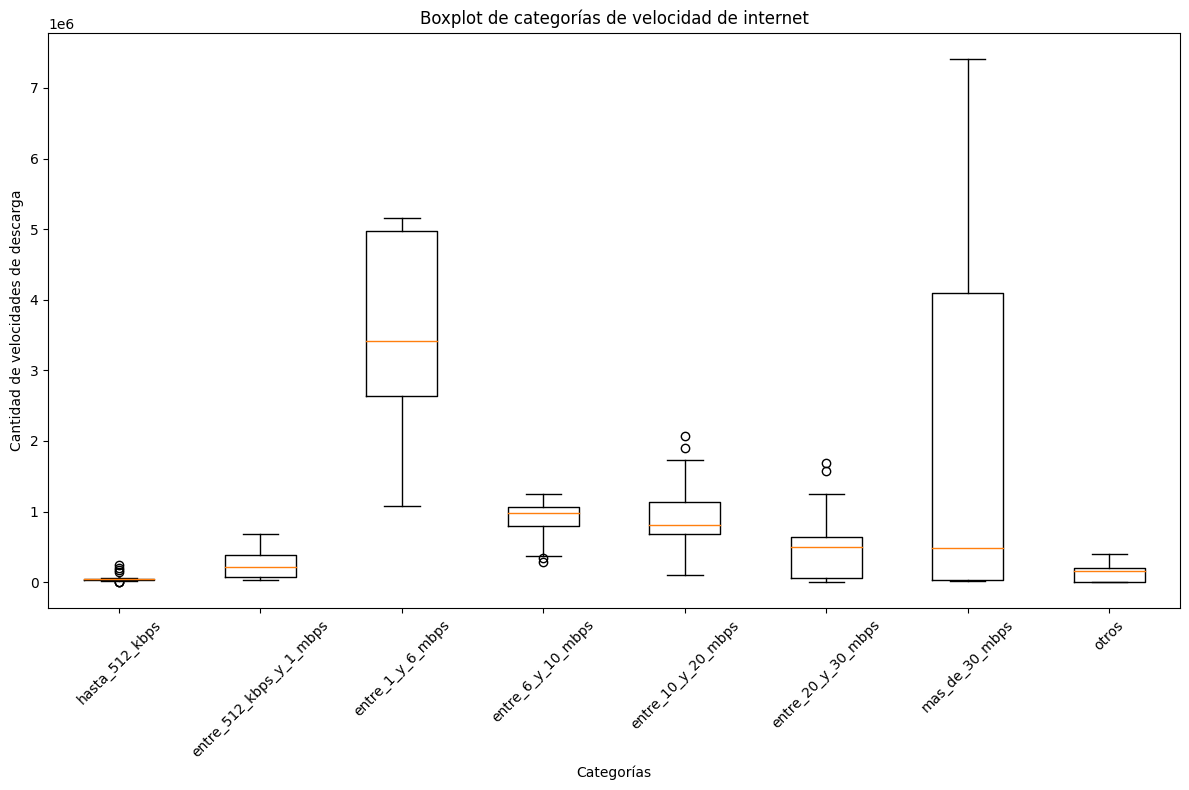

In [108]:
import matplotlib.pyplot as plt

columnas = ['hasta_512_kbps', 'entre_512_kbps_y_1_mbps', 'entre_1_y_6_mbps', 'entre_6_y_10_mbps',
                   'entre_10_y_20_mbps', 'entre_20_y_30_mbps', 'mas_de_30_mbps', 'otros']

plt.figure(figsize=(12, 8))
plt.boxplot([df_10[column] for column in columnas], labels=columnas)
plt.title('Boxplot de categorías de velocidad de internet')
plt.xlabel('Categorías')
plt.ylabel('Cantidad de velocidades de descarga')

# Rotando los labels de x porque no se veian
plt.xticks(rotation=45)
plt.tight_layout() 
plt.show()


En el boxplot de arriba se puede observar que el valor con la mediana y los cuartiles más altos es 'entre 1 y 6 mbps' de velocidad de descarga. En 'más de 30 mbps' también se pueden apreciar outliers, aunque la mediana para esa categoría es de las más bajas. No creo que sea problemático, ni necesariamente incorrecto. 

In [141]:
df_10.to_csv('df_10_mejorado.csv', index=False)

# Df_11 - Promedio de velocidad de descarga por provincia

In [99]:
import pandas as pd

In [100]:
df_11 = pd.read_csv("Data_dfs/df_11.csv")

In [101]:
df_11.head()

,anio,trimestre,provincia,hasta_512_kbps,entre_512_kbps_y_1_mbps,entre_1_mbps_y_6_mbps,entre_6_mbps_y_10_mbps,entre_10_mbps_y_20_mbps,entre_20_mbps_y_30_mbps,mas_de_30_mbps,otros,total
0,2022,4,buenos aires,28.934,23.347,259.866,281.550,244.555,98.670,3.760.109,97.634,4.794.665
1,2022,4,capital federal,516.000,5.096,31.320,64.653,36.336,8.116,1.299.117,106.772,1.551.926
2,2022,4,catamarca,71.000,315.000,2.716,5.028,4.638,3.122,52.739,2.280,70.909
3,2022,4,chaco,461.000,771.000,16.067,17.846,6.704,3.039,94.866,3.909,143.663
4,2022,4,chubut,109.000,1.614,46.457,31.007,34.728,15.770,19.048,20.026,168.759


En el df tengo datos con dos '.'. Debería ser millones pero están como flotantes, así que tengo que cambiarlos.

In [102]:
excel_11 = pd.read_excel('Excel_original/excel_11.xlsx', sheet_name='Accesos por velocidad')

In [103]:
excel_11.head(1)

,Año,Trimestre,Provincia,HASTA 512 kbps,+ 512 Kbps - 1 Mbps,+ 1 Mbps - 6 Mbps,+ 6 Mbps - 10 Mbps,+ 10 Mbps - 20 Mbps,+ 20 Mbps - 30 Mbps,+ 30 Mbps,OTROS,Total
0,2022,4,Buenos Aires,28934.0,23347.0,259866.0,281550.0,244555.0,98670.0,3760109.0,97634.0,4794665.0


In [104]:
df_11.head(1)

,anio,trimestre,provincia,hasta_512_kbps,entre_512_kbps_y_1_mbps,entre_1_mbps_y_6_mbps,entre_6_mbps_y_10_mbps,entre_10_mbps_y_20_mbps,entre_20_mbps_y_30_mbps,mas_de_30_mbps,otros,total
0,2022,4,buenos aires,28.934,23.347,259.866,281.55,244.555,98.67,3.760.109,97.634,4.794.665


Creo un df nuevo con la data del excel original para reemplazar los valores de df_11 con un for loop sencillo que recorre las una lista de las columnas del df_11, y una lista con las columnas del df_excel para reemplazar aquellas con éstas.

In [105]:
columnas_df11 = ['hasta_512_kbps', 'entre_512_kbps_y_1_mbps', 'entre_1_mbps_y_6_mbps', 'entre_6_mbps_y_10_mbps', 'entre_10_mbps_y_20_mbps', 'entre_20_mbps_y_30_mbps', 'mas_de_30_mbps', 'otros', 'total']
columnas_excel = ['HASTA 512 kbps', '+ 512 Kbps - 1 Mbps', '+ 1 Mbps - 6 Mbps', '+ 6 Mbps - 10 Mbps','+ 10 Mbps - 20 Mbps', '+ 20 Mbps - 30 Mbps', '+ 30 Mbps','OTROS', 'Total']

for column in columnas_df11:
    df_11[columnas_df11] = excel_11[columnas_excel]

Buscando nulos. Habían 6 nulos en la columna 'otros'.

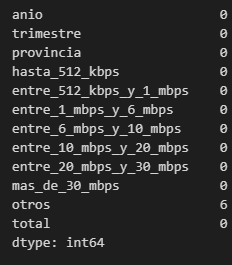

Ya no hay nulos.

In [110]:
df_11.isnull().sum()

anio                       0
trimestre                  0
provincia                  0
hasta_512_kbps             0
entre_512_kbps_y_1_mbps    0
entre_1_mbps_y_6_mbps      0
entre_6_mbps_y_10_mbps     0
entre_10_mbps_y_20_mbps    0
entre_20_mbps_y_30_mbps    0
mas_de_30_mbps             0
otros                      0
total                      0
dtype: int64

In [109]:
df_11[df_11['otros'].isnull()]

,anio,trimestre,provincia,hasta_512_kbps,entre_512_kbps_y_1_mbps,entre_1_mbps_y_6_mbps,entre_6_mbps_y_10_mbps,entre_10_mbps_y_20_mbps,entre_20_mbps_y_30_mbps,mas_de_30_mbps,otros,total


Tengo 6 valores nulos en la columna 'otros'. Los puedo averiguar haciendo 'total' - las otras columnas rapidamente. Luego reemplazo los valores de la columna 'otros' por el resultado de la resta.

In [108]:
suma_columnas = df_11[['hasta_512_kbps', 'entre_512_kbps_y_1_mbps', 'entre_1_mbps_y_6_mbps',
                       'entre_6_mbps_y_10_mbps', 'entre_10_mbps_y_20_mbps', 'entre_20_mbps_y_30_mbps', 'mas_de_30_mbps']].sum(axis=1)
df_11['otros'] = df_11['total'] - suma_columnas

Busco valores nulos de 'otros'

In [107]:
null_otros = df_11[df_11['otros'].isnull()]
print(null_otros[['total', 'otros']])

         total  otros
337  1418395.0    NaN
347    50304.0    NaN
348   222260.0    NaN
355    30010.0    NaN
358    47895.0    NaN
359   166673.0    NaN


In [113]:
df_11['provincia'].unique()

array(['buenos aires', 'capital federal', 'catamarca', 'chaco', 'chubut',
       'cordoba', 'corrientes', 'entre rios', 'formosa', 'jujuy',
       'la pampa', 'la rioja', 'mendoza', 'misiones', 'neuquen',
       'rio negro', 'salta', 'san juan', 'san luis', 'santa cruz',
       'santa fe', 'santiago del estero', 'tierra del fuego', 'tucuman'],
      dtype=object)

In [114]:
provincias = df_11['provincia'].unique()

In [126]:
df_11.head()

,anio,trimestre,provincia,hasta_512_kbps,entre_512_kbps_y_1_mbps,entre_1_mbps_y_6_mbps,entre_6_mbps_y_10_mbps,entre_10_mbps_y_20_mbps,entre_20_mbps_y_30_mbps,mas_de_30_mbps,otros,total,poblacion
0,2022,4,buenos aires,28934.0,23347.0,259866.0,281550.0,244555.0,98670.0,3760109.0,97634.0,4794665.0,17569053.0
1,2022,4,capital federal,516.0,5096.0,31320.0,64653.0,36336.0,8116.0,1299117.0,106772.0,1551926.0,3120612.0
2,2022,4,catamarca,71.0,315.0,2716.0,5028.0,4638.0,3122.0,52739.0,2280.0,70909.0,429556.0
3,2022,4,chaco,461.0,771.0,16067.0,17846.0,6704.0,3039.0,94866.0,3909.0,143663.0,1142963.0
4,2022,4,chubut,109.0,1614.0,46457.0,31007.0,34728.0,15770.0,19048.0,20026.0,168759.0,603120.0


In [118]:
poblacion = {'capital federal': 3120612, 
             'buenos aires': 17569053,
             'catamarca': 429556,
             'chaco': 1142963,
             'chubut': 603120,
             'cordoba': 3978984,
             'corrientes': 1197553,
             'entre rios': 1426426,
             'formosa': 606041,
             'jujuy': 797955,
             'la pampa': 366022,
             'la rioja': 384607,
             'mendoza': 2014533,
             'misiones': 1.280960,
             'neuquen': 726590,
             'rio negro': 762067,
             'salta': 1440672,
             'san juan': 818234,
             'san luis': 540905,
             'santa cruz': 333473,
             'santa fe': 3556522,
             'santiago del estero': 1054028,
             'tierra del fuego': 190.641,
             'tucuman ': 1703186
             }

In [119]:
# Insert the 'poblacion' column into df_11
df_11['poblacion'] = df_11['provincia'].map(poblacion)

Me parece que un gráfico de barras apiladas funcionaría bastante bien en este caso, ya que da cuenta de la distribución de las distintas categorías de velocidades de internet para cada provincia. Este tipo de gráficos permiten ver el valor total para cada categoría, mientras que también muestran cómo cada categoría contribuye al valor total. Como tengo que mostrar varias variables categóricas en un sólo gráfico, me pareció buena idea probarlo. Este es el resultado:


<Figure size 1500x1000 with 0 Axes>

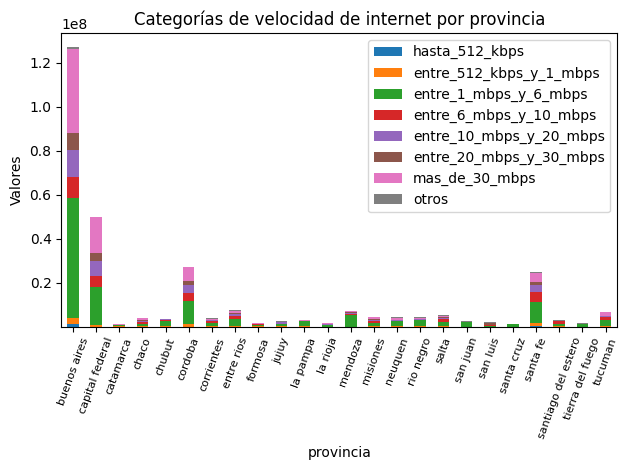

In [122]:
columnas = ['hasta_512_kbps', 'entre_512_kbps_y_1_mbps', 'entre_1_mbps_y_6_mbps',
                   'entre_6_mbps_y_10_mbps', 'entre_10_mbps_y_20_mbps', 'entre_20_mbps_y_30_mbps',
                   'mas_de_30_mbps', 'otros']

grouped = df_11.groupby('provincia')

category_sums = grouped[columnas].sum()

plt.figure(figsize=(15,10))
category_sums.plot(kind='bar', stacked=True)
plt.title('Categorías de velocidad de internet por provincia')
plt.ylabel('Valores')
plt.xticks(rotation=70, fontsize=8)
plt.tight_layout()

plt.show()

El mismo gráfico, pero quitando provincia de Buenos Aires para que se vean mejor los valores de las otra provincias.

<Figure size 1500x1000 with 0 Axes>

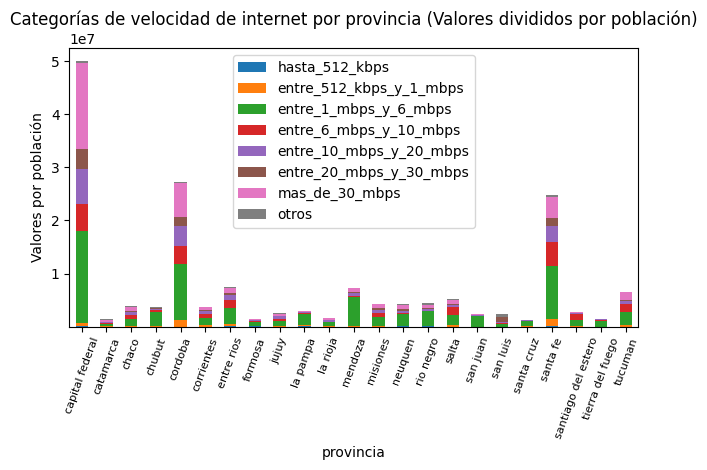

In [136]:
import pandas as pd
import matplotlib.pyplot as plt

# Calculate the sum of internet speed categories for each province
columnas = ['hasta_512_kbps', 'entre_512_kbps_y_1_mbps', 'entre_1_mbps_y_6_mbps',
            'entre_6_mbps_y_10_mbps', 'entre_10_mbps_y_20_mbps', 'entre_20_mbps_y_30_mbps',
            'mas_de_30_mbps', 'otros']

# Filter the data to exclude "buenos aires" province
filtered_df = df_11[df_11['provincia'] != 'buenos aires']

# Group by province and calculate the sum
grouped = filtered_df.groupby('provincia')[columnas].sum()

# Create the stacked bar chart
plt.figure(figsize=(15, 10))
grouped.plot(kind='bar', stacked=True)

plt.title('Categorías de velocidad de internet por provincia (Valores divididos por población)')
plt.ylabel('Valores por población')
plt.xticks(rotation=70, fontsize=8)
plt.tight_layout()

plt.show()

In [142]:
df_11.to_csv('df_11_mejorado.csv', index=False)

# df_12 - Accesos por velocidad sin rangos(categorias)

In [ ]:
import pandas as pd

In [149]:
df_12 = pd.read_csv("Data_dfs/df_12.csv")

In [152]:
df_12.head()

,Año,Trimestre,Provincia,Otros,hasta_512_kbps,entre_512_kbps_y_1_mbps,entre_1_mbps_y_6_mbps,entre_6_mbps_y_10_mbps,entre_10_mbps_y_20_mbps,entre_20_mbps_y_30_mbps,mas_de_30_mbps
0,NaN,NaN,buenos aires,97.634,46.724,196.611,414.140,1673.088,999.744,1062.938,2853.689
1,NaN,NaN,capital federal,106.772,482.000,35.307,1299.755,37.729,99.683,68.793,447.095
2,NaN,NaN,catamarca,2.280,34.000,37.000,1480.000,2.551,1154.027,899.717,923.388
3,NaN,NaN,chaco,3.909,459.000,113.000,2024.497,816.213,156.845,753.062,48.841
4,NaN,NaN,chubut,20.026,77.000,868.000,808.726,334.377,84.177,18.332,185.008


# Df_13 - Ingresos por trimestre

In [137]:
import pandas as pd

In [138]:
df_13 = pd.read_csv("Data_dfs/df_13.csv")

In [139]:
df_13.head()

,anio,trimestre,periodo,ingresos
0,2022,4,oct-dic 2022,72000
1,2022,3,jul-sept 2022,64000
2,2022,2,abr-jun 2022,60000
3,2022,1,ene-mar 2022,55000
4,2021,4,oct-dic 2021,45000


La columna ingresos está poco clara en este df, además de tener los datos poco precisos. Nuevamente, voy a importar los datos del excel original.

In [140]:
excel_13 = pd.read_excel('Excel_original/excel_13.xlsx', sheet_name='Ingresos')

In [141]:
excel_13.head(2)

,Año,Trimestre,Ingresos (miles de pesos),Periodo
0,2022,4,7.244348e+07,Oct-Dic 2022
1,2022,3,6.408678e+07,Jul-Sept 2022


In [142]:
df_13['ingresos'] = excel_13['Ingresos (miles de pesos)']

Los valores fueron reemplazados, pero el nombre de la columna 'ingresos' de df_13 es poco claro. El valor es de ingresos en miles de pesos. Así que lo voy a cambiar.

In [144]:
df_13.rename(columns={'ingresos': 'ingresos_en_miles_de_pesos'}, inplace=True)

In [145]:
df_13.head()

,anio,trimestre,periodo,ingresos_en_miles_de_pesos
0,2022,4,oct-dic 2022,7.244348e+07
1,2022,3,jul-sept 2022,6.408678e+07
2,2022,2,abr-jun 2022,6.041950e+07
3,2022,1,ene-mar 2022,5.521931e+07
4,2021,4,oct-dic 2021,4.546789e+07


Buscando valores duplicados. Quiero ver que no hayan valores duplicados de la combinación anio-trimestre

In [208]:
columnas = ['anio', 'trimestre']

duplicados = df_13.duplicated(subset=columnas)

filas_duplicadas = df_13[duplicados]

filas_duplicadas

,anio,trimestre,periodo,ingresos_en_miles_de_pesos


Buscando valores nulos

In [183]:
df_13.isnull().sum()

anio                          0
trimestre                     0
periodo                       0
ingresos_en_miles_de_pesos    0
dtype: int64

Buscando outliers:

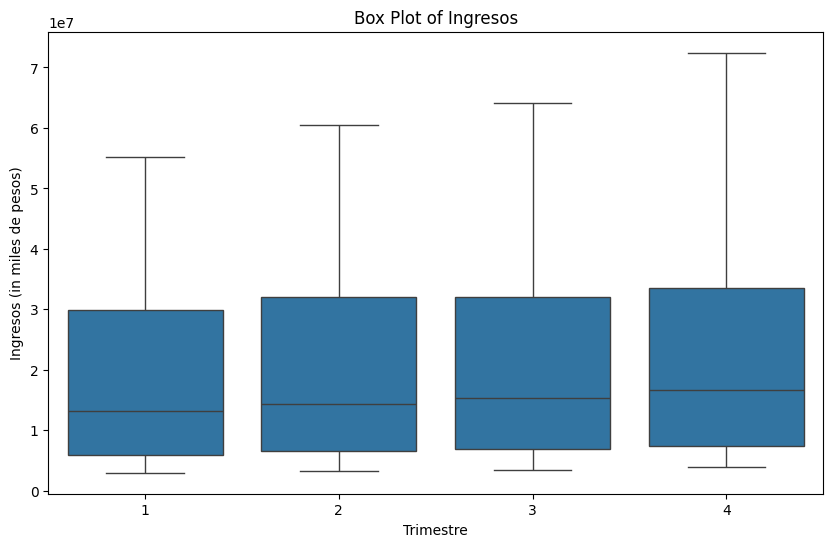

In [184]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(x='trimestre', y='ingresos_en_miles_de_pesos', data=df_13, showfliers=True)
plt.title('Box Plot de Ingresos por Trimestr')
plt.xlabel('Trimestre')
plt.ylabel('Ingresos (in miles de pesos)')
plt.show()

La información para los distintos trimestres parece casi perfectamente distribuida, lo que habla muy bien de la calidad de los datos.

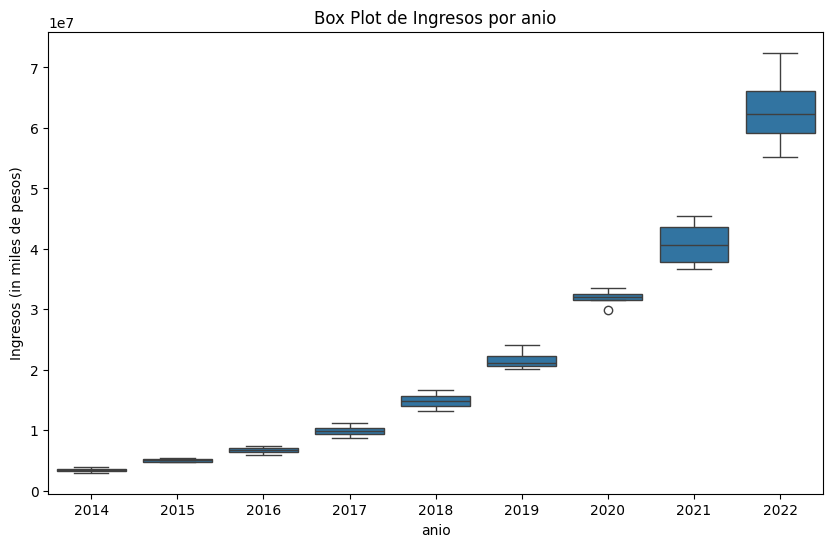

In [186]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(x='anio', y='ingresos_en_miles_de_pesos', data=df_13, showfliers=True)
plt.title('Box Plot de Ingresos por anio')
plt.xlabel('anio')
plt.ylabel('Ingresos (in miles de pesos)')
plt.show()

In [188]:
df_13.to_csv('df_13_mejorado.csv', index=False)

# Df_14

In [146]:
import pandas as pd

In [187]:
df_14 = pd.read_csv("Data_dfs/df_14.csv")

In [189]:
df_14.head()

,hasta_512_kbps,entre_512_kbps_y_1_mbps,entre_1_mbps_y_6_mbps,entre_6_mbps_y_10_mbps,entre_10_mbps_y_20_mbps,entre_20_mbps_y_30_mbps,mas_de_30_mbps
0,2.0,19.0,230.0,493.0,595.965,857.0,146.0
1,0.0,0.0,0.0,46.0,13.000,0.0,0.0
2,1.0,0.0,181.0,0.0,10.000,0.0,0.0
3,0.0,0.0,66.0,0.0,0.000,0.0,0.0
4,0.0,0.0,172.0,7.0,1.000,0.0,1.0


# Df_15 - Tipos de conexiones por Localidad.

In [147]:
import pandas as pd

In [148]:
df_15 = pd.read_csv("Data_dfs/df_15.csv")

In [220]:
df_15.head()

,provincia,partido,localidad,link_indec,adsl,cablemodem,dial_up,fibra_optica,otros,satelital,wimax,wireless,total_general
0,buenos aires,25 de mayo,25 de mayo,6854100,874.0,4.54,0.0,3.0,0.0,852,0,706.0,6.98
1,buenos aires,25 de mayo,del valle,6854020,181.0,0.00,0.0,0.0,10.0,1,0,0.0,192.00
2,buenos aires,25 de mayo,gobernador ugarte,6854040,0.0,0.00,0.0,0.0,0.0,0,0,181.0,181.00
3,buenos aires,25 de mayo,norberto de la riestra,6854060,0.0,782.00,0.0,6.0,167.0,0,0,327.0,1.28
4,buenos aires,25 de mayo,lucas monteverde,6854050,0.0,0.00,0.0,0.0,0.0,0,0,6.0,6.00


In [221]:
df_15.shape

(3137, 13)

El df es de cantidad de distintas conexiones por localidad. Los datos tienen unidades poco claras, así que voy a importar los datos originales del excel provisto por la página oficial.

In [149]:
excel_15 = pd.read_excel('Excel_original/excel_15.xlsx', sheet_name='Accesos_tecnologia_localidad')

In [152]:
excel_15.head(5)

,Provincia,Partido,Localidad,Link Indec,ADSL,CABLEMODEM,DIAL UP,FIBRA OPTICA,OTROS,SATELITAL,WIMAX,WIRELESS,Total general
0,BUENOS AIRES,25 de Mayo,25 de Mayo,6854100,874,4542,0,3,0,852,0,706,6977
1,BUENOS AIRES,25 de Mayo,Del Valle,6854020,181,0,0,0,10,1,0,0,192
2,BUENOS AIRES,25 de Mayo,Gobernador Ugarte,6854040,0,0,0,0,0,0,0,181,181
3,BUENOS AIRES,25 de Mayo,Norberto de la Riestra,6854060,0,782,0,6,167,0,0,327,1282
4,BUENOS AIRES,25 de Mayo,Lucas Monteverde,6854050,0,0,0,0,0,0,0,6,6


Reemplazando los valores de las columnas con un for loop sencillo. Recorre la lista de columnas del df_15 cuyos valores deben ser reemplazados, y las reemplaza por los valores de las columnas de excel_15.

In [153]:
columnas_df15 = ['adsl', 'cablemodem', 'dial_up', 'fibra_optica', 'otros', 'satelital', 'wimax', 'wireless', 'total_general']
columnas_excel = ['ADSL', 'CABLEMODEM', 'DIAL UP', 'FIBRA OPTICA','OTROS', 'SATELITAL', 'WIMAX','WIRELESS', 'Total general']

for column in columnas_df15:
    df_15[columnas_df15] = excel_15[columnas_excel]

Buscando valores nulos

In [226]:
df_15.isnull().sum()

provincia        0
partido          0
localidad        0
link_indec       0
adsl             0
cablemodem       0
dial_up          0
fibra_optica     0
otros            0
satelital        0
wimax            0
wireless         0
total_general    0
dtype: int64

Buscando valores duplicados. En este caso lo importante es que no se repita la localidad. 

In [227]:
columnas = ['provincia','partido', 'localidad']

duplicados = df_15.duplicated(subset=columnas)

filas_duplicadas = df_15[duplicados]

filas_duplicadas

,provincia,partido,localidad,link_indec,adsl,cablemodem,dial_up,fibra_optica,otros,satelital,wimax,wireless,total_general
1243,cordoba,san justo,transito,sin datos,0,943,0,133,0,0,0,0,1076


Tengo un duplicado en la localidad de 'transito', pero ambas filas aportan valores, así que voy a tomar lo mejor de ambas y las voy a combinar, para luego borrar una.

In [154]:
df_15[df_15['localidad'] == 'transito']

,provincia,partido,localidad,link_indec,adsl,cablemodem,dial_up,fibra_optica,otros,satelital,wimax,wireless,total_general
1233,cordoba,san justo,transito,14140400,71,0,0,0,0,0,0,106,177
1243,cordoba,san justo,transito,sin datos,0,943,0,133,0,0,0,0,1076


In [155]:
df_15.loc[1243, 'adsl'] = df_15.loc[1233, 'adsl']
df_15.loc[1243, 'wireless'] = df_15.loc[1233, 'wireless']

In [156]:
df_15.drop(1233, inplace=True)

Solo me queda corregir el valor 'total' para que represente la suma de los demás valores.

In [157]:
suma = df_15.loc[1243, ['adsl', 'cablemodem', 'dial_up', 'fibra_optica', 'otros', 'satelital', 'wimax', 'wireless']].sum()

df_15.loc[1243, 'total_general'] = suma

Explorando los datos vi que habían muchas localidades = 'otros'. Los voy a borrar, ya que ninguno representa una cantidad significativa de conexiones y es un df de localidades.

In [158]:
# df_15[df_15['localidad'] == 'otros']

,provincia,partido,localidad,link_indec,adsl,cablemodem,dial_up,fibra_optica,otros,satelital,wimax,wireless,total_general
88,buenos aires,bolivar,otros,sin datos,0,1,0,1,0,0,0,0,2
200,buenos aires,ezeiza,otros,sin datos,3,1,0,5,0,0,0,0,9
238,buenos aires,general lavalle,otros,sin datos,0,0,0,1,0,0,0,0,1
258,buenos aires,general pueyrredon,otros,sin datos,0,0,0,151,0,0,0,0,151
267,buenos aires,general san martin,otros,sin datos,11,0,0,0,0,0,0,0,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2874,santa fe,san justo,otros,sin datos,0,0,0,0,0,28,0,0,28
3022,santiago del estero,ojo de agua,otros,sin datos,0,0,0,0,0,4,0,0,4
3025,santiago del estero,otros,otros,sin datos,0,0,0,0,310,0,0,0,310
3070,tucuman,burruyacu,otros,sin datos,0,0,0,0,0,1,0,0,1


In [159]:
df_15 = df_15[df_15['localidad'] != 'otros']

In [235]:
df_15.to_csv('df_15_mejorado.csv', index=False)

# Df_16

In [160]:
df_16 = pd.read_csv("Data_dfs/df_16.csv")

In [161]:
df_16.head()

,provincia,partido,localidad,adsl,cablemodem,dial_up,fibra_optica,4g,3g,telefonia_fija,wireless,satelital
0,buenos aires,9 de julio,alfredo demarchi (est. facundo quiroga),si,--,--,--,si,si,si,--,--
1,buenos aires,9 de julio,carlos maria naon,--,--,--,--,si,si,si,--,--
2,buenos aires,9 de julio,dudignac,--,--,si,--,si,si,si,si,--
3,buenos aires,9 de julio,la aurora (est. la nina),--,--,--,--,si,--,--,--,--
4,buenos aires,9 de julio,manuel b. gonnet (est. french),si,--,--,si,si,si,si,--,--


In [239]:
# Duplicados
columnas = ['provincia', 'partido', 'localidad']

duplicados = df_16.duplicated(subset=columnas)

filas_duplicadas = df_16[duplicados]

filas_duplicadas

,provincia,partido,localidad,adsl,cablemodem,dial_up,fibra_optica,4g,3g,telefonia_fija,wireless,satelital
353,buenos aires,la plata,ruta del sol,si,--,--,si,si,si,si,--,--
2418,entre rios,colon,hocker,--,--,--,--,si,--,--,si,si
2863,la rioja,sanagasta,villa sanagasta,--,si,--,si,si,si,si,si,si
3225,mendoza,guaymallen,colonia segovia,--,--,--,si,si,si,--,si,--
3442,tucuman,cruz alta,lastenia,--,--,--,--,si,si,--,--,--
3813,entre rios,parana,el ramblon,--,--,--,--,si,--,--,si,--


In [240]:
df_16.shape

(4311, 12)

In [162]:
excel_16 = pd.read_excel('Excel_original/excel_16.xlsx', sheet_name='Hoja3')

In [163]:
excel_16.head(4)

,Provincia,Partido,Localidad,Población,ADSL,Cablemódem,Dial Up,Fibra óptica,Satelital,Wireless,Telefonía Fija,3G,4G,Link,Latitud,Longitud
0,BUENOS AIRES,9 de Julio,Alfredo Demarchi (Est. Facundo Quiroga),1853,SI,--,--,--,--,--,SI,SI,SI,6588010.0,-35.292982,-61.407254
1,BUENOS AIRES,9 de Julio,Carlos María Naón,497,--,--,--,--,--,--,SI,SI,SI,6588020.0,-35.239499,-60.825136
2,BUENOS AIRES,9 de Julio,Dudignac,2670,--,--,SI,--,--,SI,SI,SI,SI,6588040.0,-35.651193,-60.709896
3,BUENOS AIRES,9 de Julio,La Aurora (Est. La Niña),531,--,--,--,--,--,--,--,--,SI,6588050.0,-35.407947,-61.210567


In [244]:
excel_16.shape

(4311, 16)